# Packages 

In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import os
import logging
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scripts.train_config import raw_data_path
from scripts.train_config import train_config_detail, data_dir, debug, debug_num, model_dir
from scripts.train_config import big_data_dir
from src.config import regression_label, submission_cols, offline_feature_path
from src.utils.memory_utils import reduce_mem_usage
from src.utils import check_create_dir
from src.utils.plot_utils import count_plot, plot_feature_importances, value_count_stats, stats_plot


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Config 

In [14]:
base_dir = '../'
dir_mark = '0503_lgbmranker_v2'

In [15]:
# target_col = train_config_detail[dir_mark]['target_col']
pipeline_class = train_config_detail[dir_mark]['pipeline_class']
feature_creator_class = train_config_detail[dir_mark]['feature_creator']
model_params = train_config_detail[dir_mark].get('model_params', {})
# grid_search_dict = train_config_detail[dir_mark].get('grid_search_dict', None)
# model_params = train_config_detail[dir_mark].get('model_params', {})
train_valid = train_config_detail[dir_mark].get('train_valid', False)
dense_features = train_config_detail[dir_mark].get('dense_features', None)
sparse_features = train_config_detail[dir_mark].get('sparse_features', None)
feature_clean_func = train_config_detail[dir_mark].get('feature_clean_func', None)

additional_train_params = train_config_detail[dir_mark].get('additional_train_params', {})

model_path = os.path.join(model_dir, dir_mark)

target_raw_data_dir = os.path.join(raw_data_path, dir_mark)
item_feature_creator = train_config_detail[dir_mark].get('item_feature_creator', None)

feature_cols = dense_features + sparse_features

check_create_dir(target_raw_data_dir)
additional_train_params = train_config_detail[dir_mark].get('additional_train_params', {})

logging.info(f"Reading data from {data_dir}")
all_df = pd.read_pickle(os.path.join(base_dir, data_dir, 'train.pkl'))
# test_df = pd.read_pickle(os.path.join(base_dir, big_data_dir, 'test.pkl'))

# Basic info 

In [16]:
all_df.shape

(9917530, 54)

# Sparse Feature 

In [17]:
sparse_features

['site_id',
 'visitor_location_country_id',
 'prop_country_id',
 'srch_destination_id',
 'prop_brand_bool',
 'promotion_flag',
 'srch_saturday_night_bool',
 'random_bool',
 'comp1_rate',
 'comp1_inv',
 'comp2_rate',
 'comp2_inv',
 'comp3_rate',
 'comp3_inv',
 'comp4_rate',
 'comp4_inv',
 'comp5_rate',
 'comp5_inv',
 'comp6_rate',
 'comp6_inv',
 'comp7_rate',
 'comp7_inv',
 'comp8_rate',
 'comp8_inv',
 'month',
 'hour',
 'dayofweek']

col: site_id
Unique number: 34

Top 5 (value: number):

   site_id  sample_num      frac    cumsum
0        5     6164803  0.621607  0.621607
1       14      964105  0.097212  0.718819
2       15      618620  0.062376  0.781195
3       24      475893  0.047985  0.829180
4       32      355805  0.035876  0.865057

Bottom 5 (value: number):

    site_id  sample_num      frac    cumsum
29        3        7015  0.000707  0.999347
30        6        4807  0.000485  0.999832
31       33        1355  0.000137  0.999969
32       20         248  0.000025  0.999994
33        8          62  0.000006  1.000000


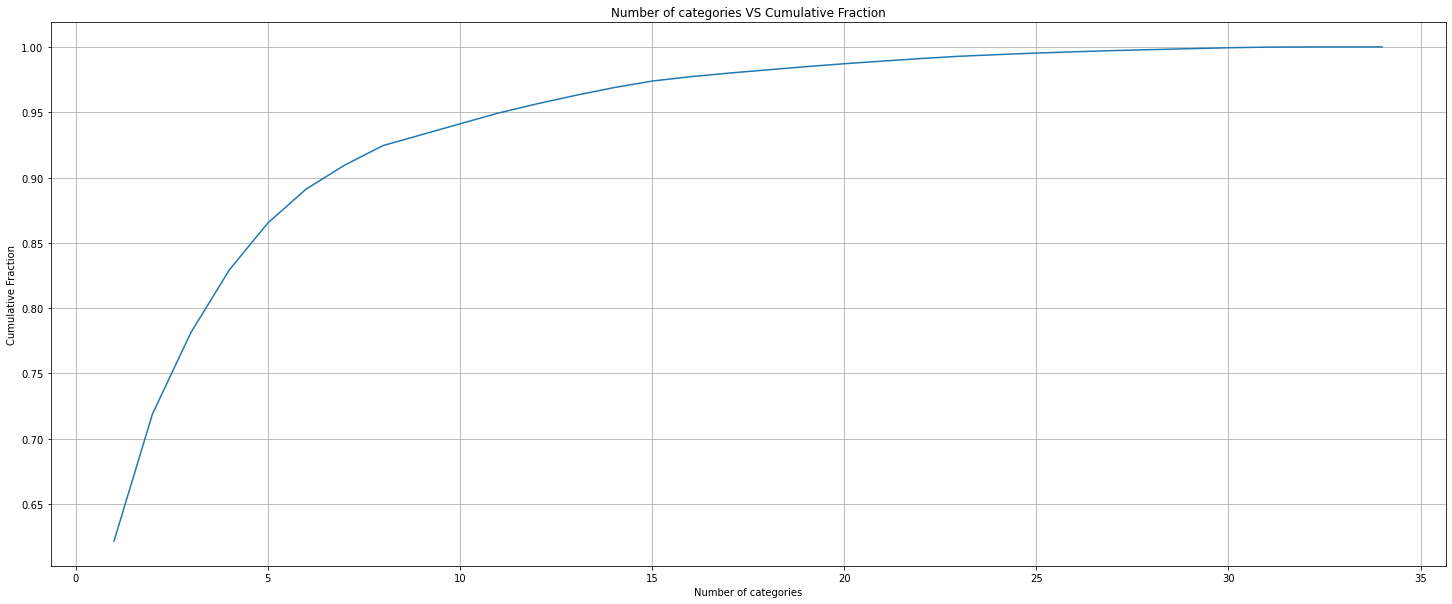

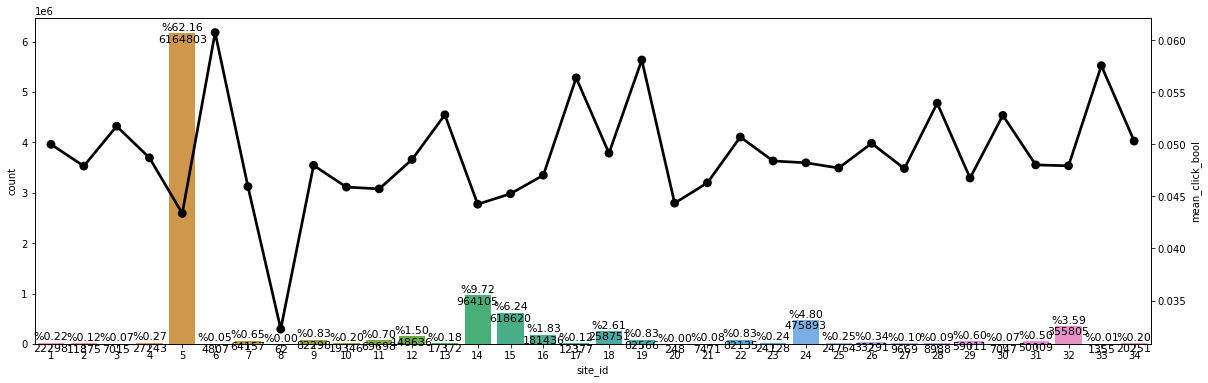

col: visitor_location_country_id
Unique number: 218

Top 5 (value: number):

   visitor_location_country_id  sample_num      frac    cumsum
0                          219     5778805  0.582686  0.582686
1                          100      990487  0.099872  0.682558
2                           55      580072  0.058490  0.741048
3                          216      434568  0.043818  0.784866
4                          220      350433  0.035335  0.820201

Bottom 5 (value: number):

     visitor_location_country_id  sample_num      frac    cumsum
213                           54          31  0.000003  0.999988
214                          198          30  0.000003  0.999991
215                          146          30  0.000003  0.999994
216                           24          29  0.000003  0.999997
217                            8          27  0.000003  1.000000


<Figure size 1440x432 with 0 Axes>

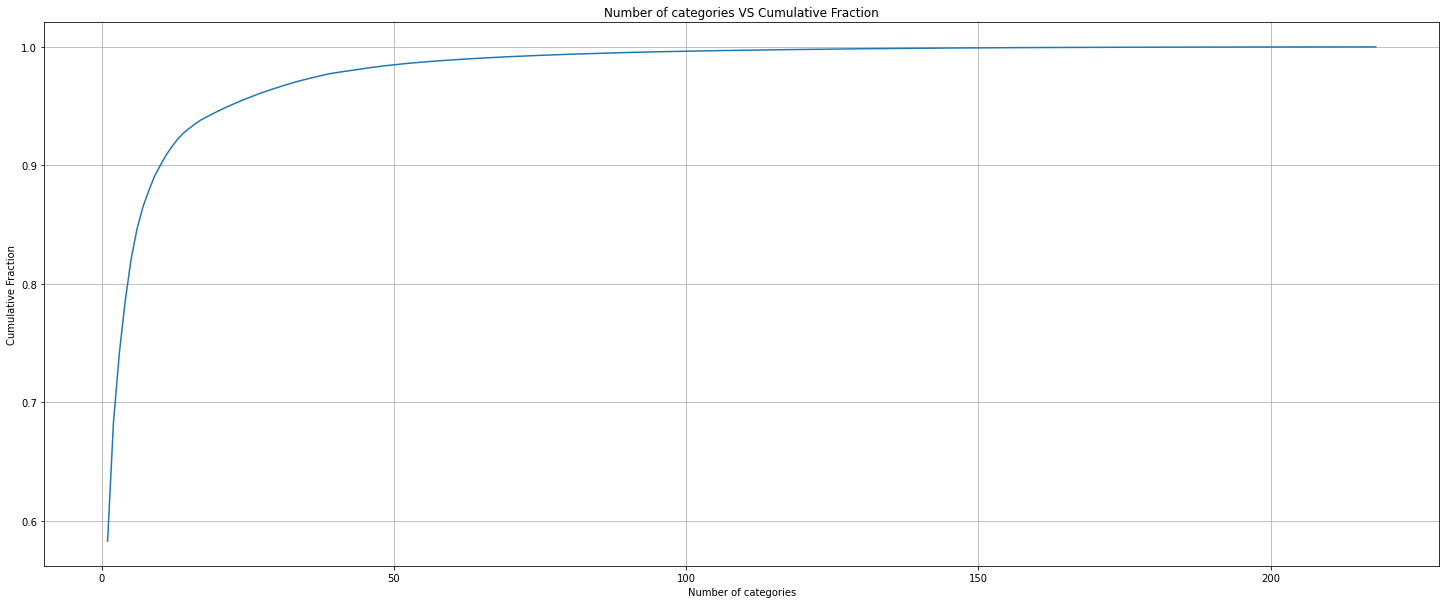

Unique num too huge: 218; cut to 10 categories
col: prop_country_id
Unique number: 172

Top 5 (value: number):

   prop_country_id  sample_num      frac    cumsum
0              219     6052976  0.610331  0.610331
1              100      622810  0.062799  0.673130
2               55      376219  0.037935  0.711065
3               31      309434  0.031201  0.742265
4               99      268393  0.027062  0.769328

Bottom 5 (value: number):

     prop_country_id  sample_num          frac    cumsum
167               79          16  1.613305e-06  0.999996
168               87          13  1.310810e-06  0.999997
169              204          10  1.008316e-06  0.999998
170                7          10  1.008316e-06  0.999999
171              165           7  7.058209e-07  1.000000


<Figure size 1440x432 with 0 Axes>

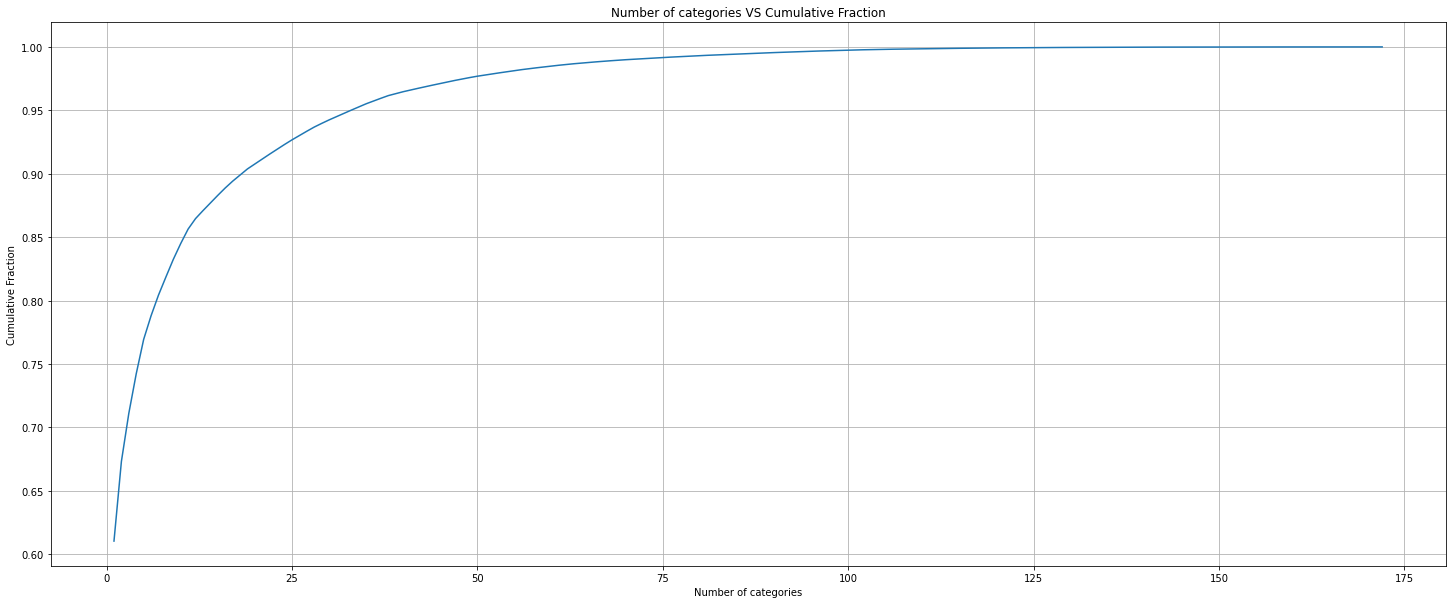

Unique num too huge: 172; cut to 10 categories
col: srch_destination_id
Unique number: 23715

Top 5 (value: number):

   srch_destination_id  sample_num      frac    cumsum
0                 8192      140182  0.014135  0.014135
1                 4562      114350  0.011530  0.025665
2                 9402       82842  0.008353  0.034018
3                10979       69369  0.006995  0.041013
4                 8347       64198  0.006473  0.047486

Bottom 5 (value: number):

       srch_destination_id  sample_num          frac    cumsum
23710                 5061           5  5.041578e-07  0.999998
23711                 8376           5  5.041578e-07  0.999998
23712                 3407           5  5.041578e-07  0.999999
23713                25669           5  5.041578e-07  0.999999
23714                13185           5  5.041578e-07  1.000000


<Figure size 1440x432 with 0 Axes>

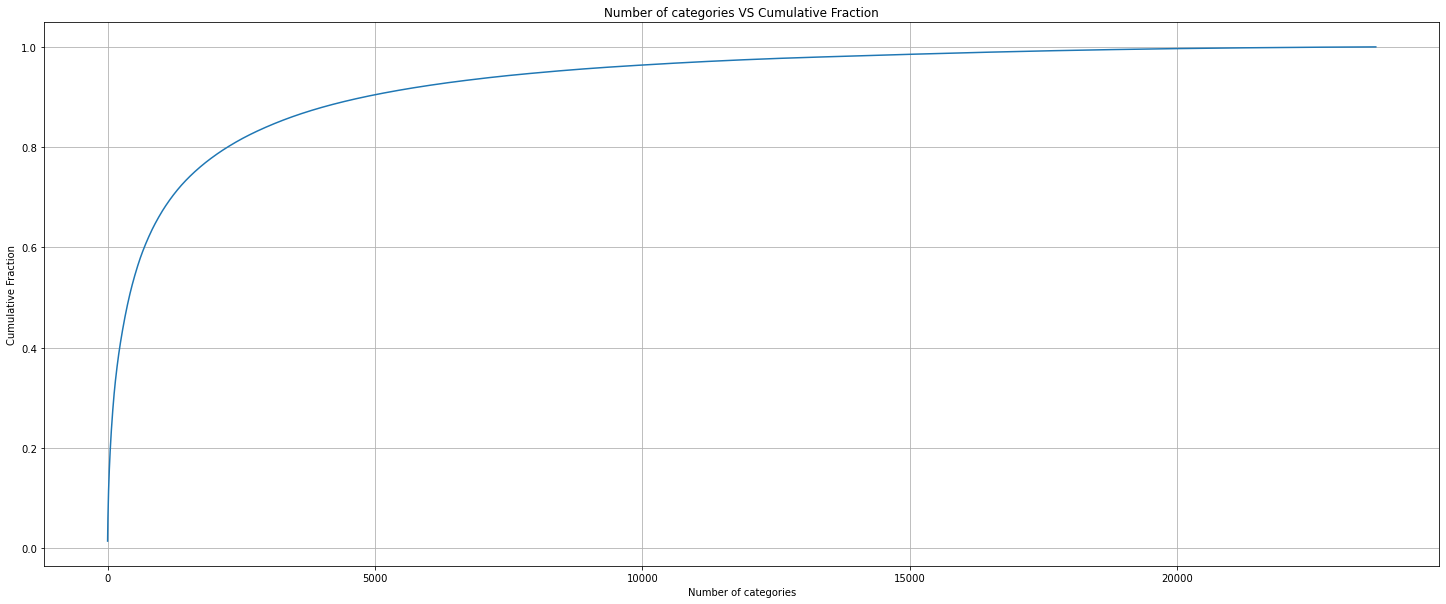

Unique num too huge: 23715; cut to 10 categories


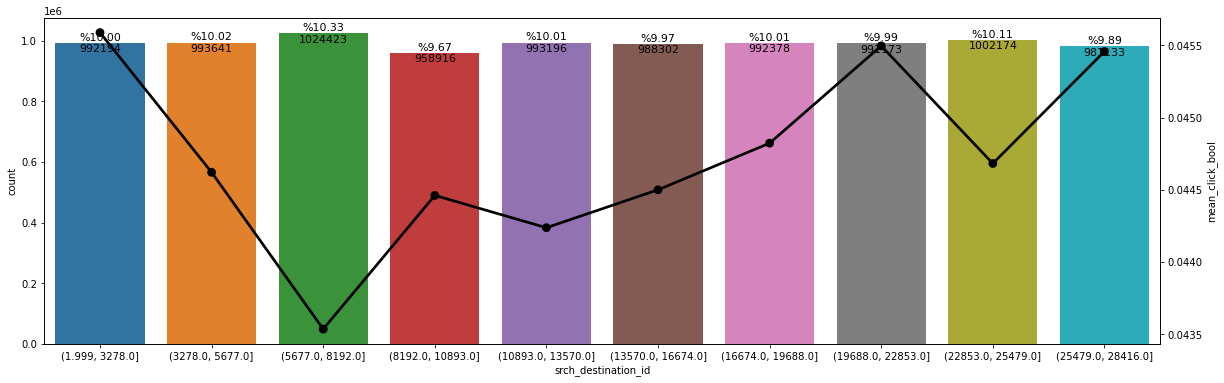

col: prop_brand_bool
Unique number: 2

Top 5 (value: number):

   prop_brand_bool  sample_num      frac    cumsum
0                1     6290731  0.634304  0.634304
1                0     3626799  0.365696  1.000000

Bottom 5 (value: number):

   prop_brand_bool  sample_num      frac    cumsum
0                1     6290731  0.634304  0.634304
1                0     3626799  0.365696  1.000000


<Figure size 1440x432 with 0 Axes>

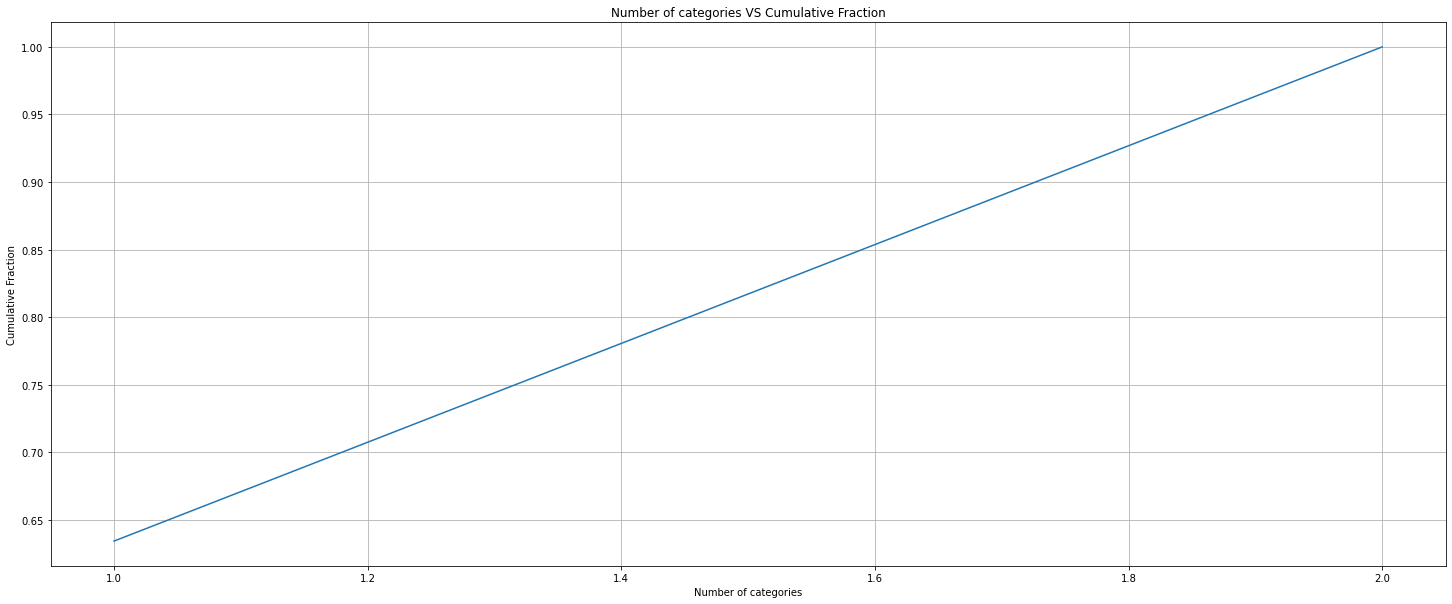

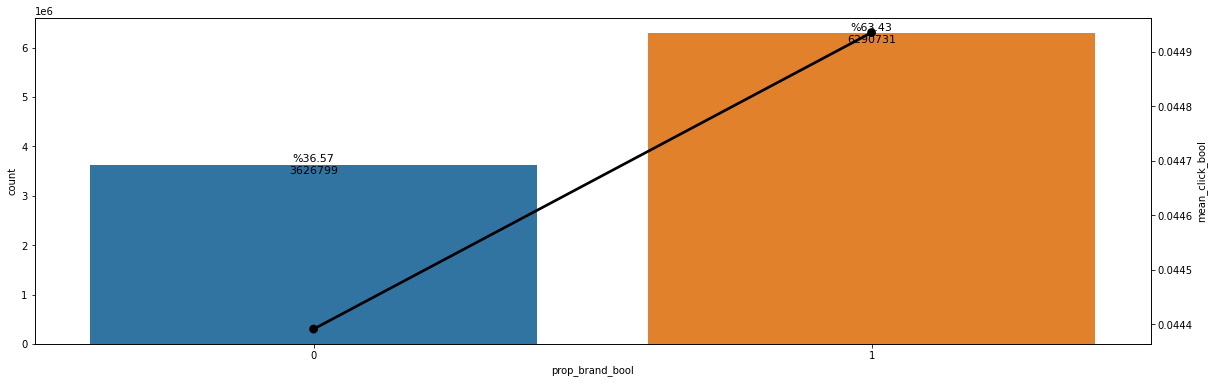

col: promotion_flag
Unique number: 2

Top 5 (value: number):

   promotion_flag  sample_num      frac    cumsum
0               0     7777708  0.784238  0.784238
1               1     2139822  0.215762  1.000000

Bottom 5 (value: number):

   promotion_flag  sample_num      frac    cumsum
0               0     7777708  0.784238  0.784238
1               1     2139822  0.215762  1.000000


<Figure size 1440x432 with 0 Axes>

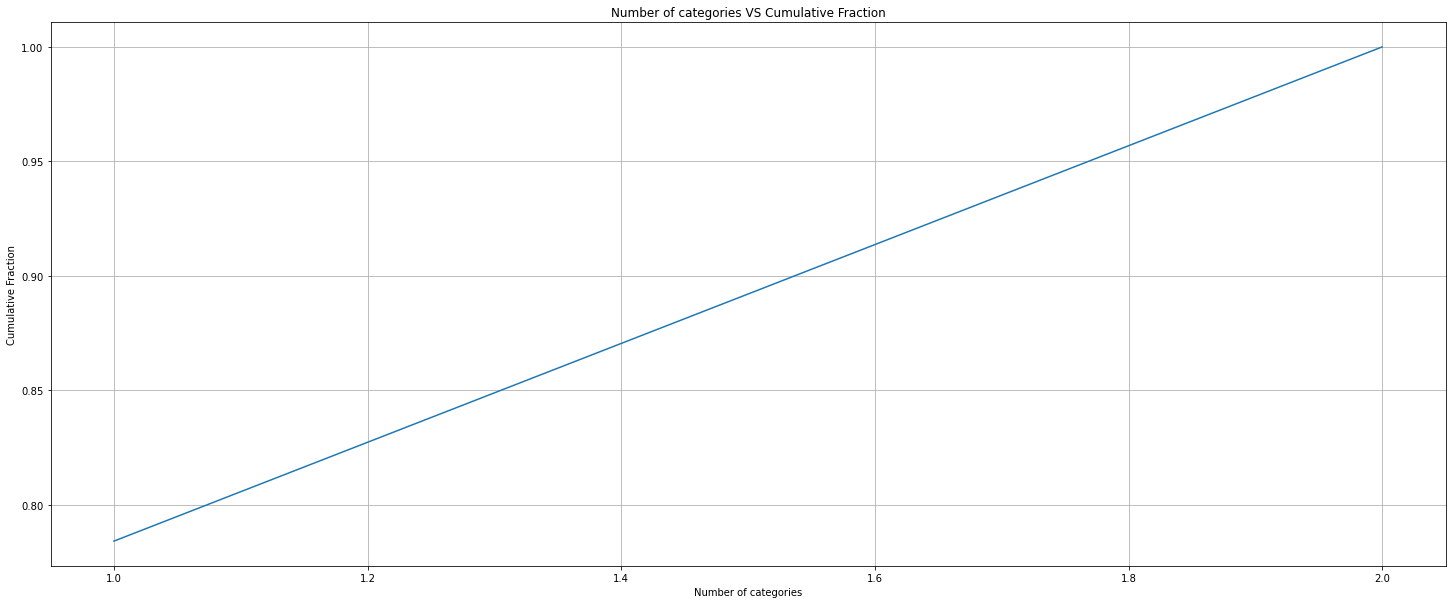

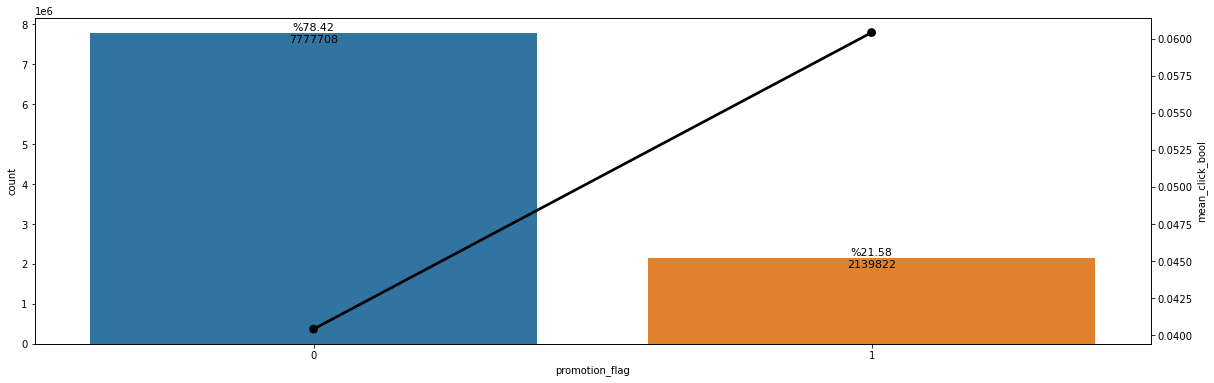

col: srch_saturday_night_bool
Unique number: 2

Top 5 (value: number):

   srch_saturday_night_bool  sample_num      frac    cumsum
0                         1     4961307  0.500256  0.500256
1                         0     4956223  0.499744  1.000000

Bottom 5 (value: number):

   srch_saturday_night_bool  sample_num      frac    cumsum
0                         1     4961307  0.500256  0.500256
1                         0     4956223  0.499744  1.000000


<Figure size 1440x432 with 0 Axes>

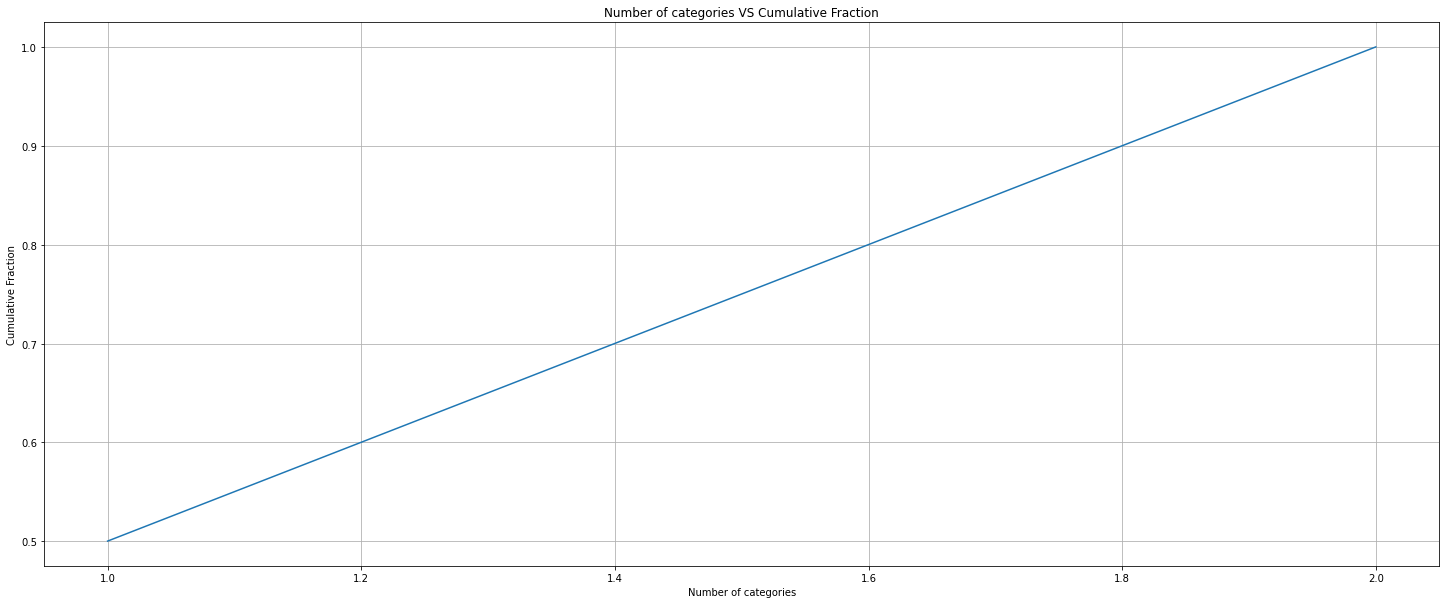

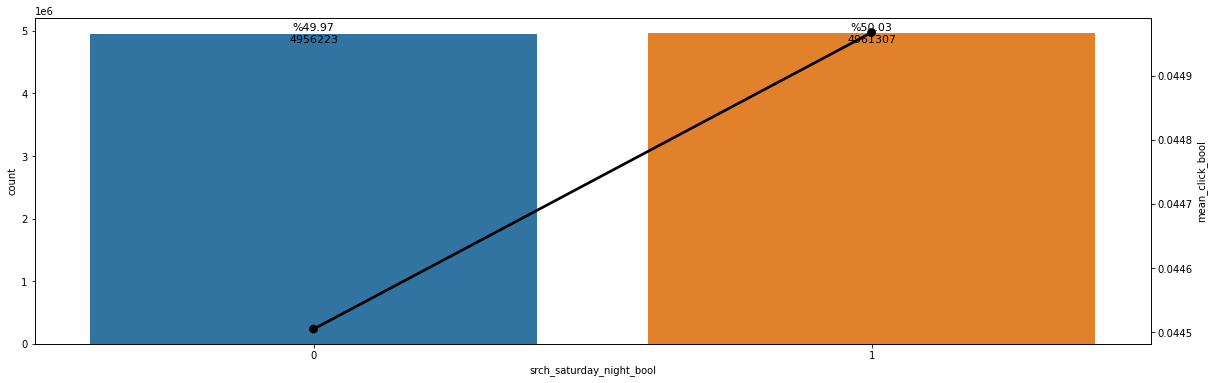

col: random_bool
Unique number: 2

Top 5 (value: number):

   random_bool  sample_num     frac   cumsum
0            0     6977878  0.70359  0.70359
1            1     2939652  0.29641  1.00000

Bottom 5 (value: number):

   random_bool  sample_num     frac   cumsum
0            0     6977878  0.70359  0.70359
1            1     2939652  0.29641  1.00000


<Figure size 1440x432 with 0 Axes>

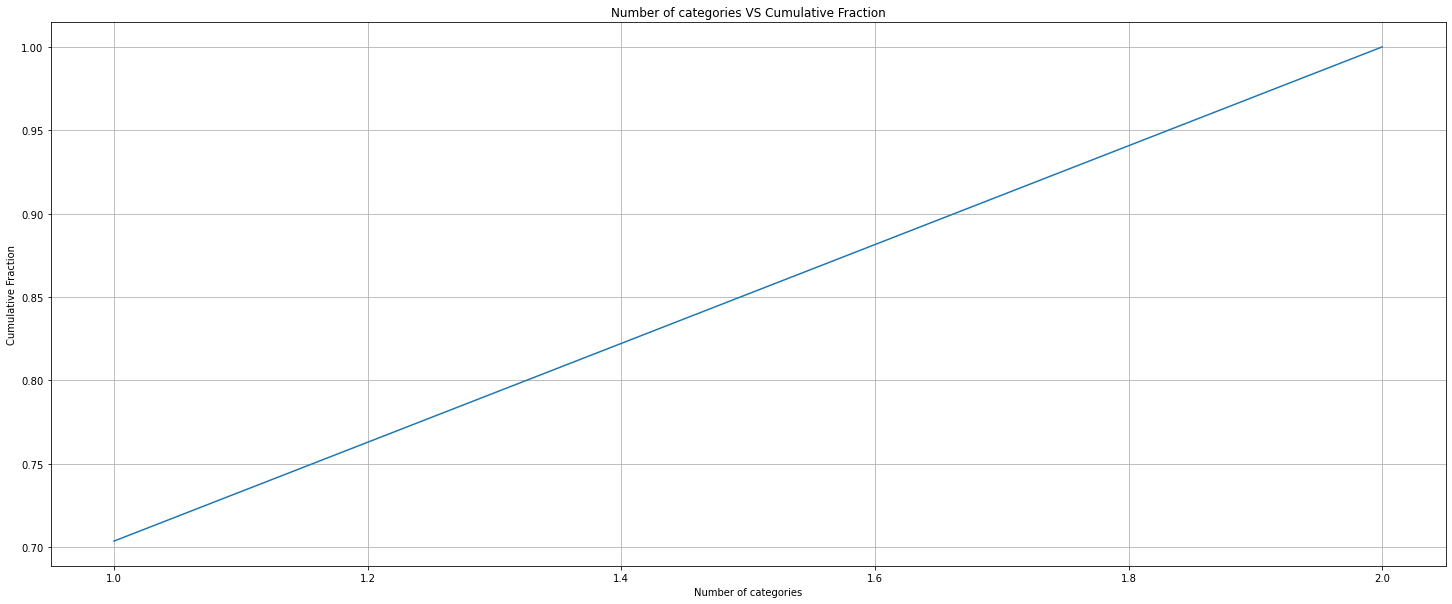

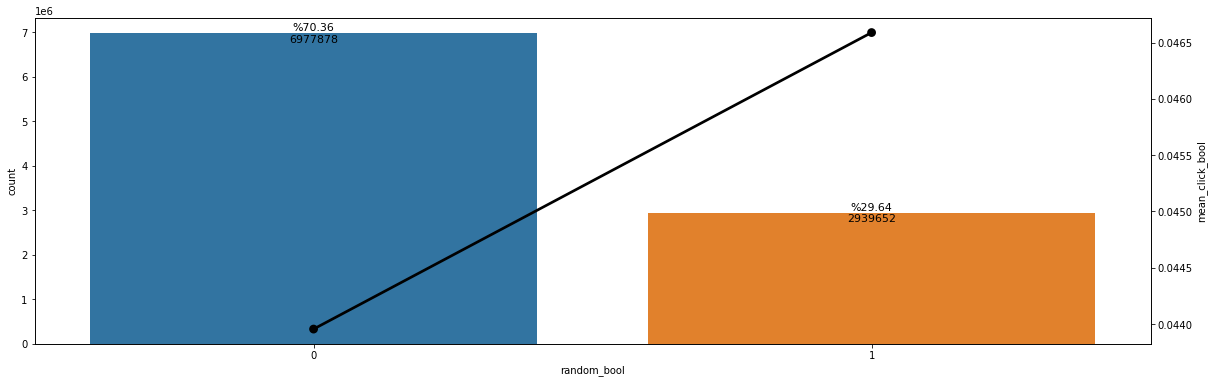

col: comp1_rate
Unique number: 4

Top 5 (value: number):

   comp1_rate  sample_num      frac    cumsum
0         1.0      132077  0.013318  0.013318
1         0.0       84558  0.008526  0.021844
2        -1.0       19171  0.001933  0.023777

Bottom 5 (value: number):

   comp1_rate  sample_num      frac    cumsum
0         1.0      132077  0.013318  0.013318
1         0.0       84558  0.008526  0.021844
2        -1.0       19171  0.001933  0.023777


<Figure size 1440x432 with 0 Axes>

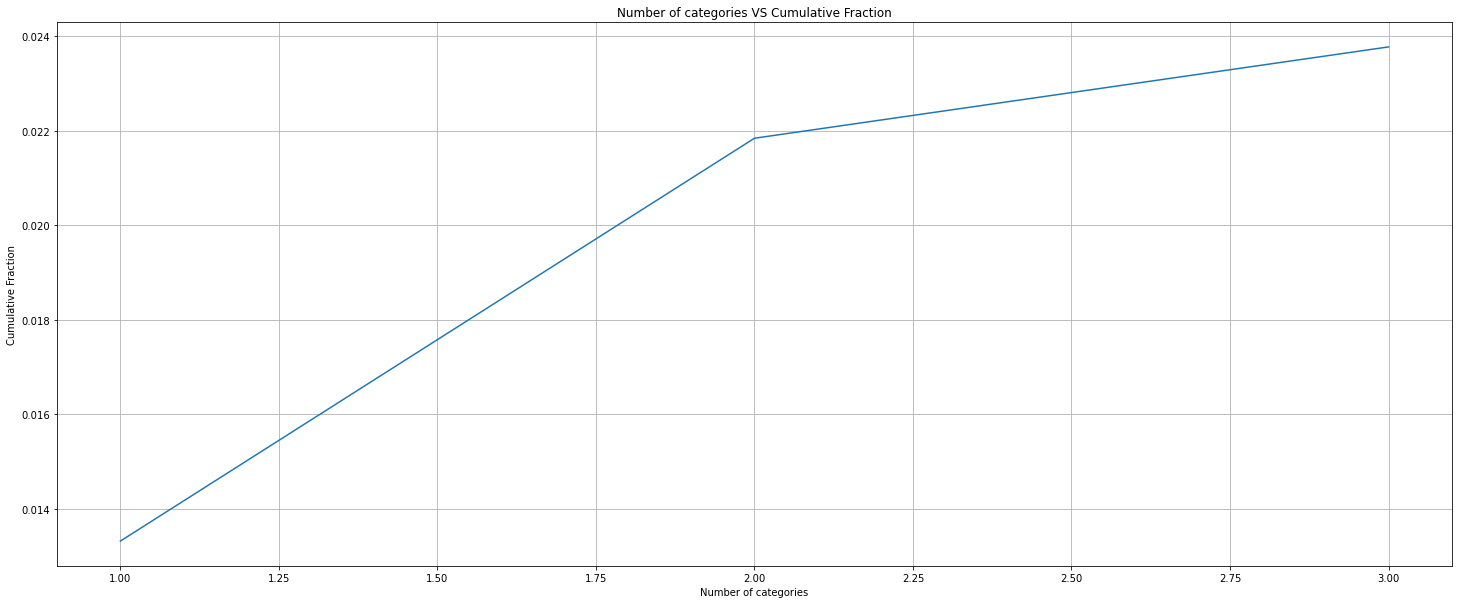

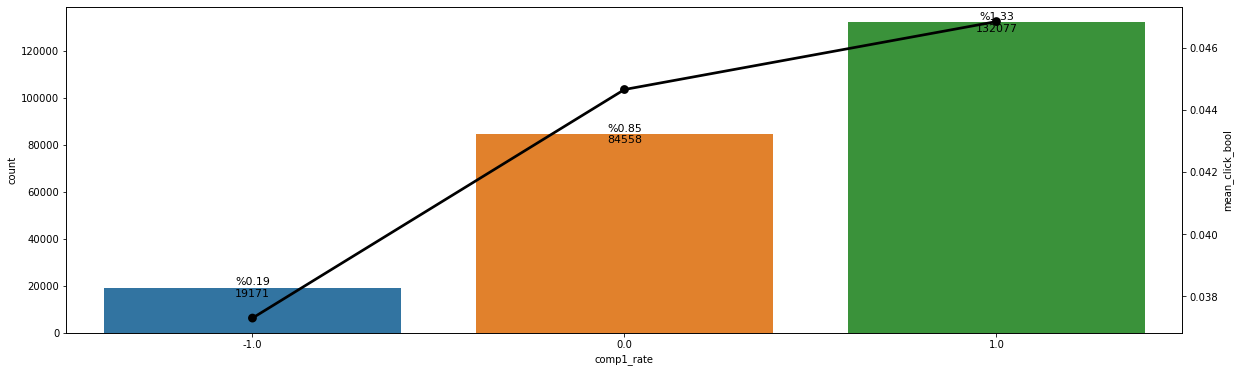

col: comp1_inv
Unique number: 4

Top 5 (value: number):

   comp1_inv  sample_num      frac    cumsum
0        0.0      241050  0.024305  0.024305
1        1.0       10533  0.001062  0.025368
2       -1.0        2850  0.000287  0.025655

Bottom 5 (value: number):

   comp1_inv  sample_num      frac    cumsum
0        0.0      241050  0.024305  0.024305
1        1.0       10533  0.001062  0.025368
2       -1.0        2850  0.000287  0.025655


<Figure size 1440x432 with 0 Axes>

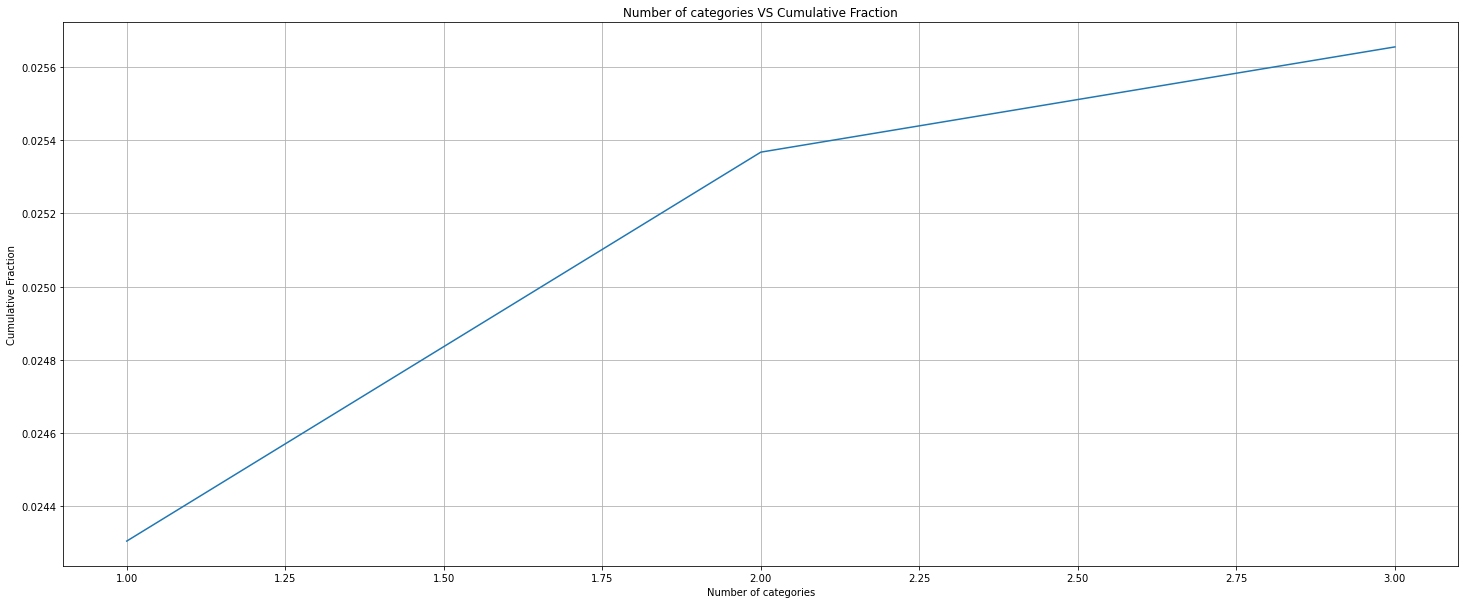

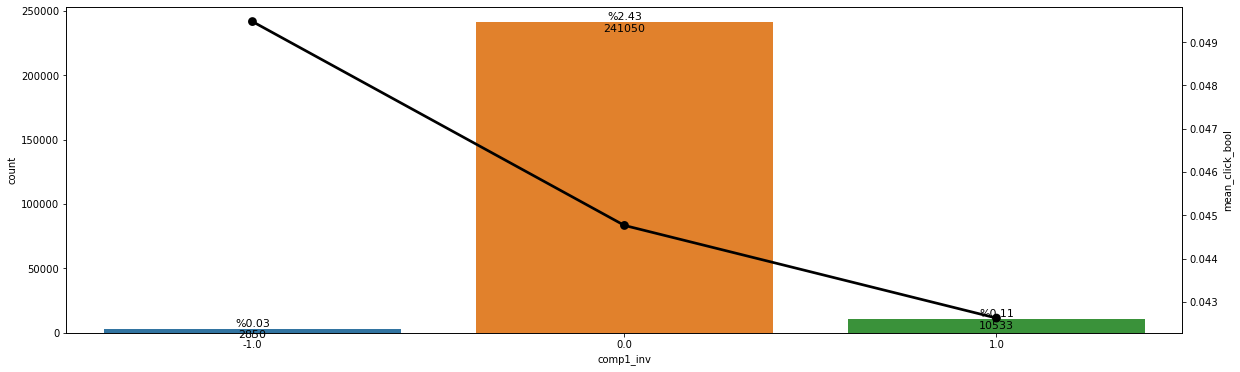

col: comp2_rate
Unique number: 4

Top 5 (value: number):

   comp2_rate  sample_num      frac    cumsum
0         0.0     3221003  0.324779  0.324779
1         1.0      499985  0.050414  0.375193
2        -1.0      319645  0.032230  0.407423

Bottom 5 (value: number):

   comp2_rate  sample_num      frac    cumsum
0         0.0     3221003  0.324779  0.324779
1         1.0      499985  0.050414  0.375193
2        -1.0      319645  0.032230  0.407423


<Figure size 1440x432 with 0 Axes>

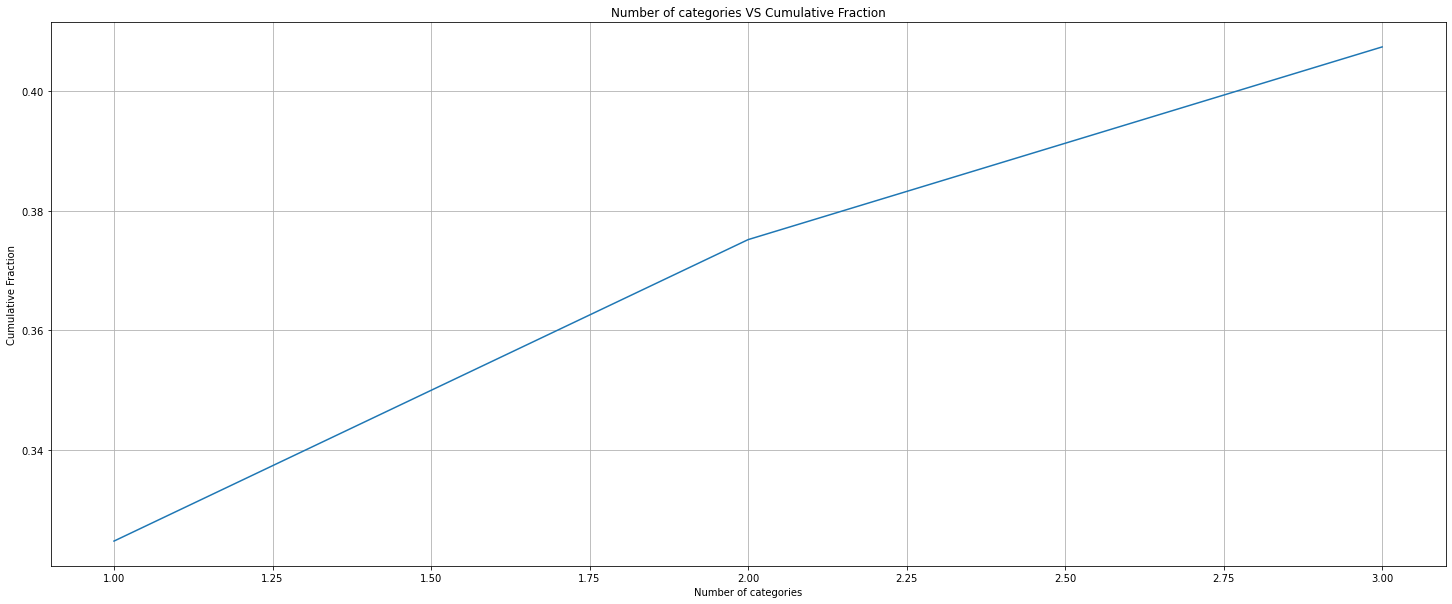

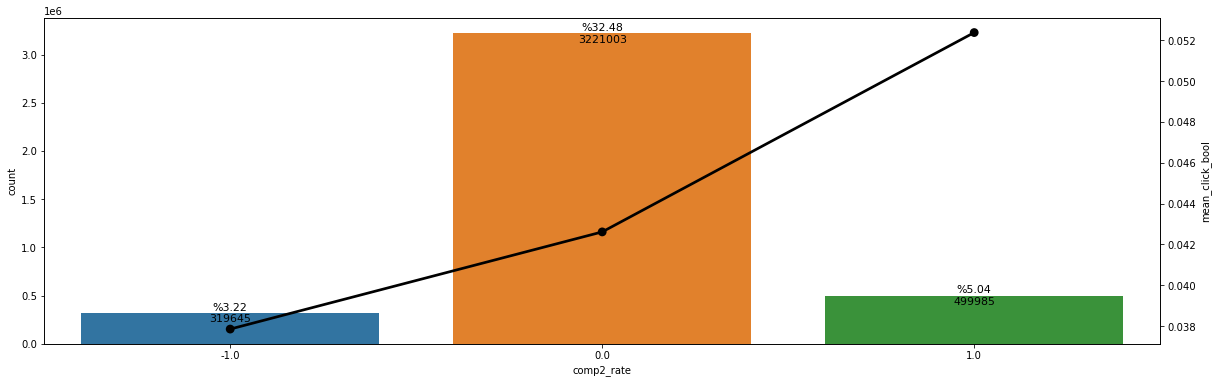

col: comp2_inv
Unique number: 4

Top 5 (value: number):

   comp2_inv  sample_num      frac    cumsum
0        0.0     4011180  0.404454  0.404454
1        1.0      204286  0.020598  0.425052
2       -1.0       36072  0.003637  0.428689

Bottom 5 (value: number):

   comp2_inv  sample_num      frac    cumsum
0        0.0     4011180  0.404454  0.404454
1        1.0      204286  0.020598  0.425052
2       -1.0       36072  0.003637  0.428689


<Figure size 1440x432 with 0 Axes>

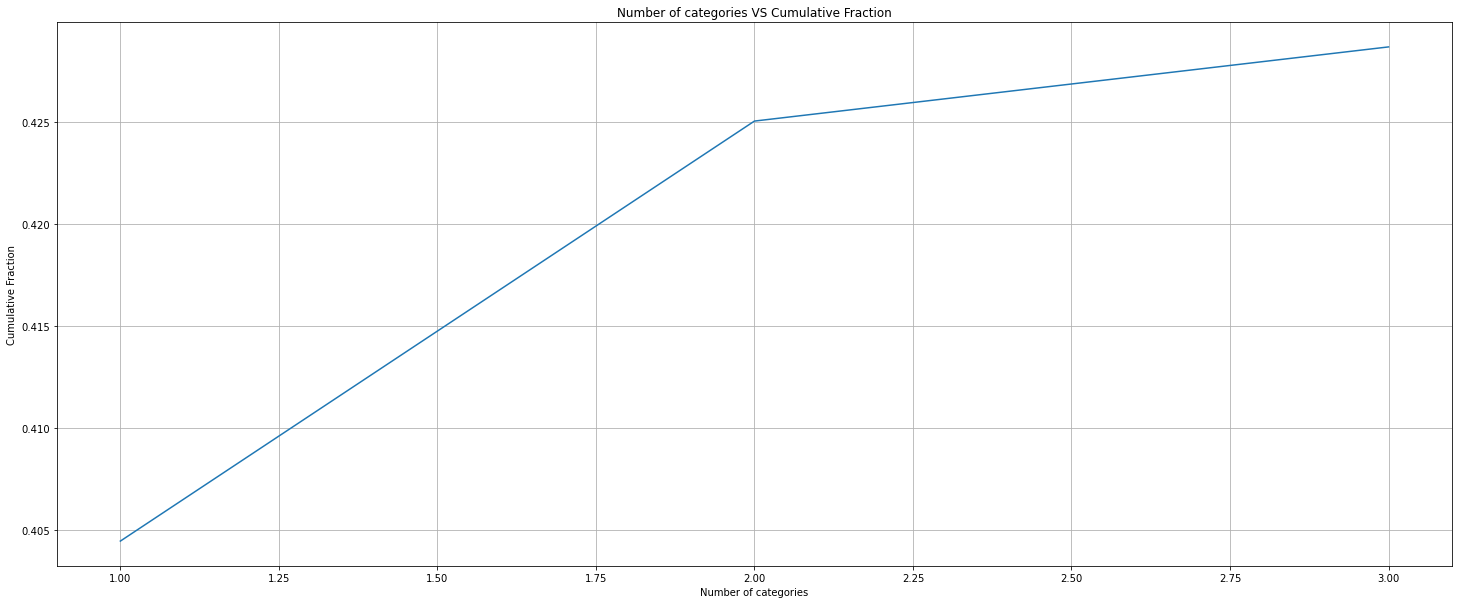

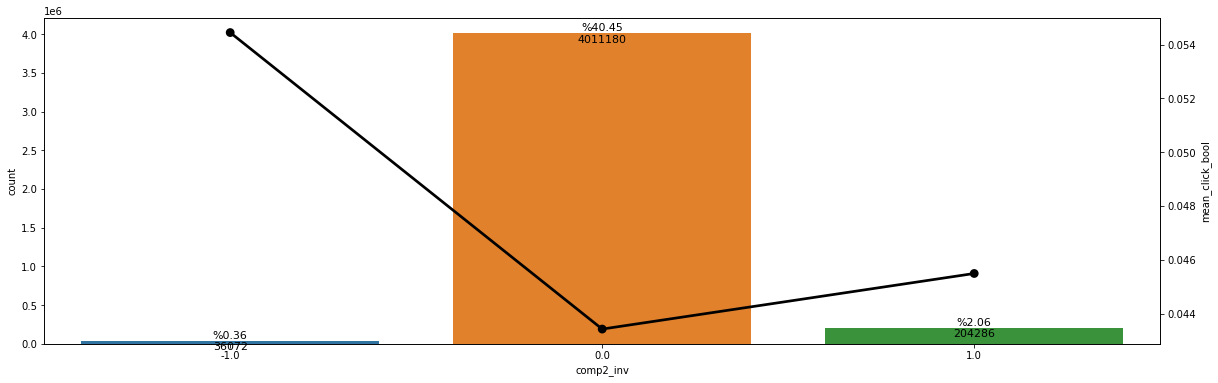

col: comp3_rate
Unique number: 4

Top 5 (value: number):

   comp3_rate  sample_num      frac    cumsum
0         0.0     2417159  0.243726  0.243726
1         1.0      347919  0.035081  0.278807
2        -1.0      294195  0.029664  0.308471

Bottom 5 (value: number):

   comp3_rate  sample_num      frac    cumsum
0         0.0     2417159  0.243726  0.243726
1         1.0      347919  0.035081  0.278807
2        -1.0      294195  0.029664  0.308471


<Figure size 1440x432 with 0 Axes>

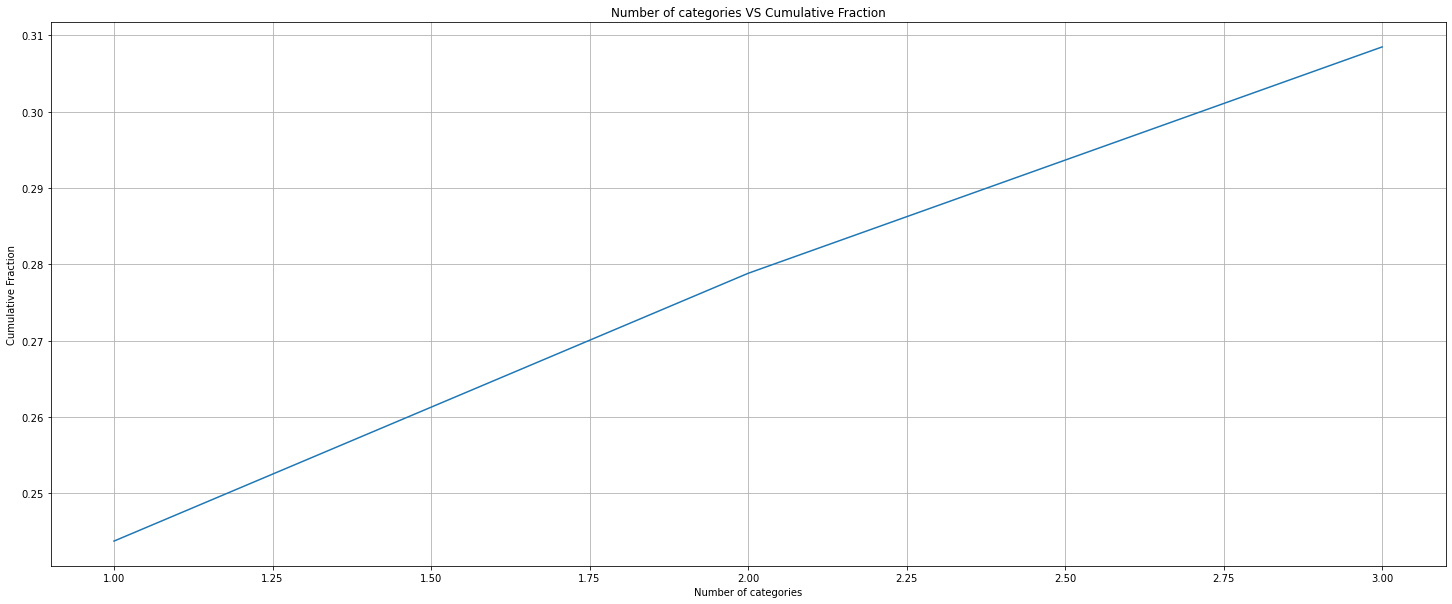

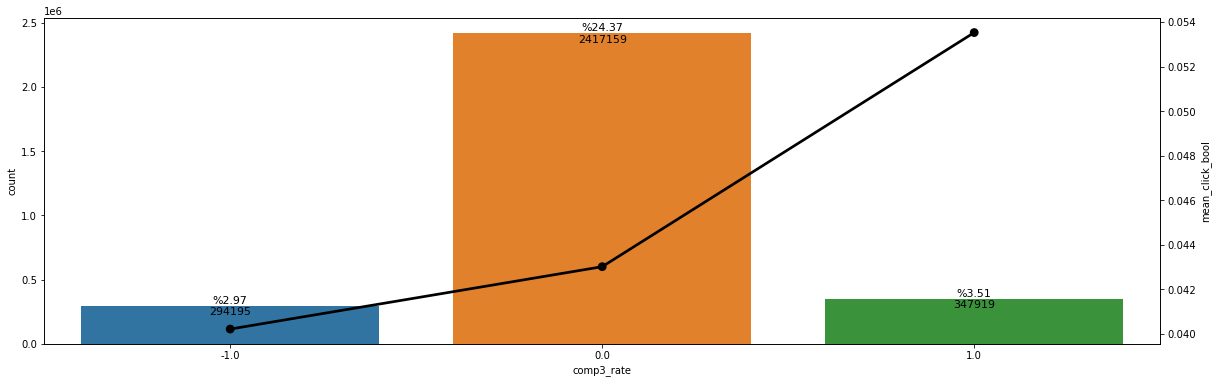

col: comp3_inv
Unique number: 4

Top 5 (value: number):

   comp3_inv  sample_num      frac    cumsum
0        0.0     2995501  0.302041  0.302041
1        1.0      242930  0.024495  0.326536
2       -1.0       53790  0.005424  0.331960

Bottom 5 (value: number):

   comp3_inv  sample_num      frac    cumsum
0        0.0     2995501  0.302041  0.302041
1        1.0      242930  0.024495  0.326536
2       -1.0       53790  0.005424  0.331960


<Figure size 1440x432 with 0 Axes>

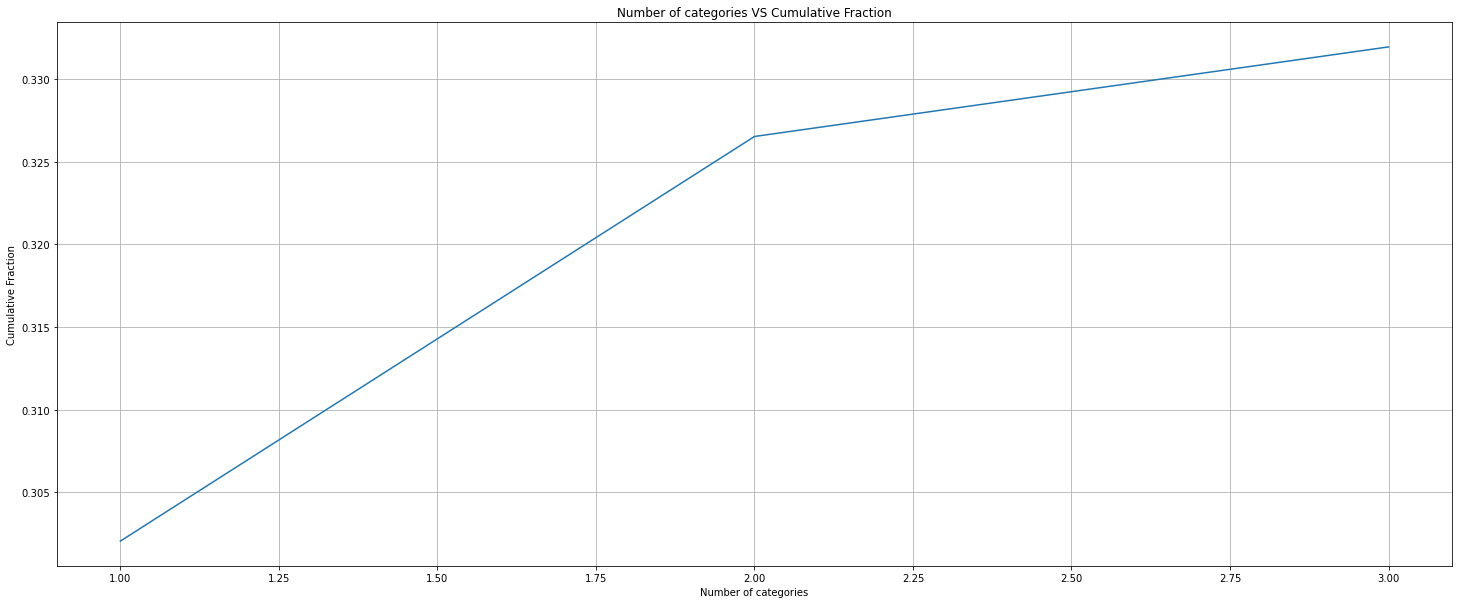

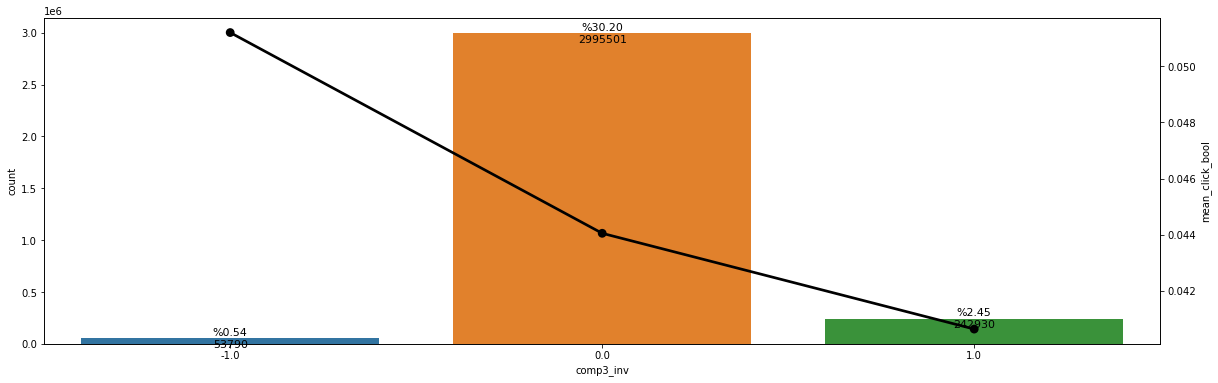

col: comp4_rate
Unique number: 4

Top 5 (value: number):

   comp4_rate  sample_num      frac    cumsum
0         0.0      413459  0.041690  0.041690
1        -1.0      108532  0.010943  0.052633
2         1.0       98108  0.009892  0.062526

Bottom 5 (value: number):

   comp4_rate  sample_num      frac    cumsum
0         0.0      413459  0.041690  0.041690
1        -1.0      108532  0.010943  0.052633
2         1.0       98108  0.009892  0.062526


<Figure size 1440x432 with 0 Axes>

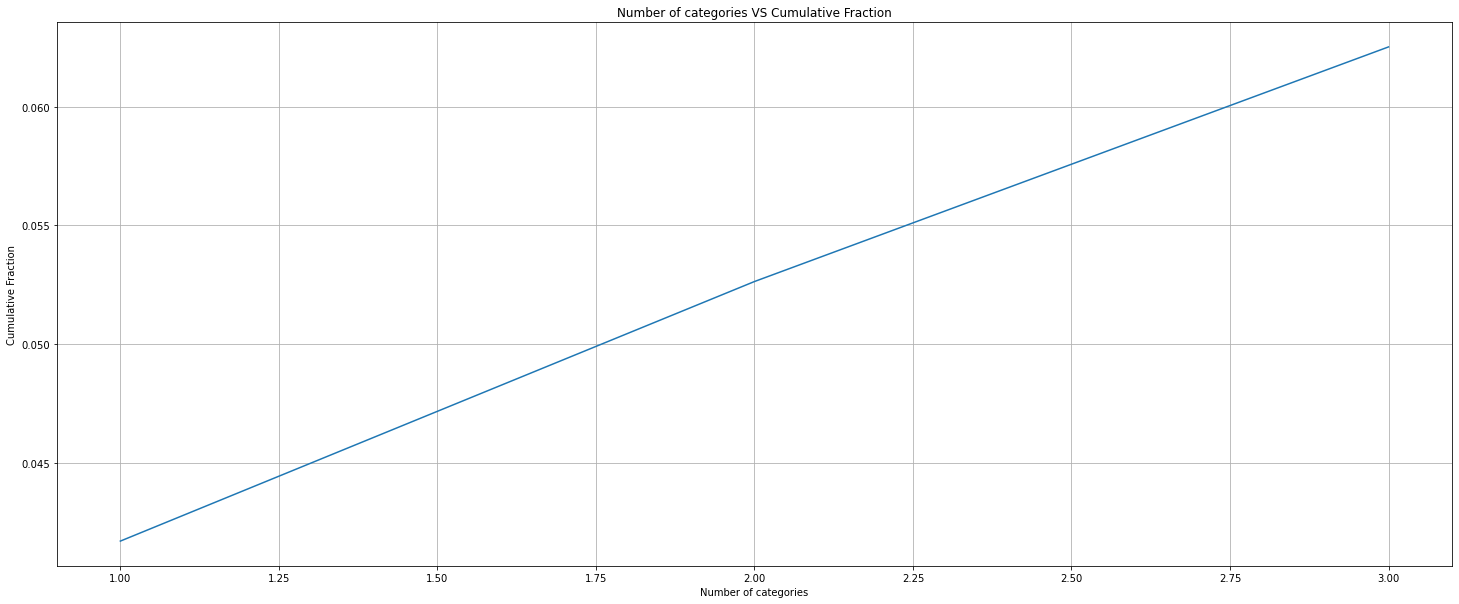

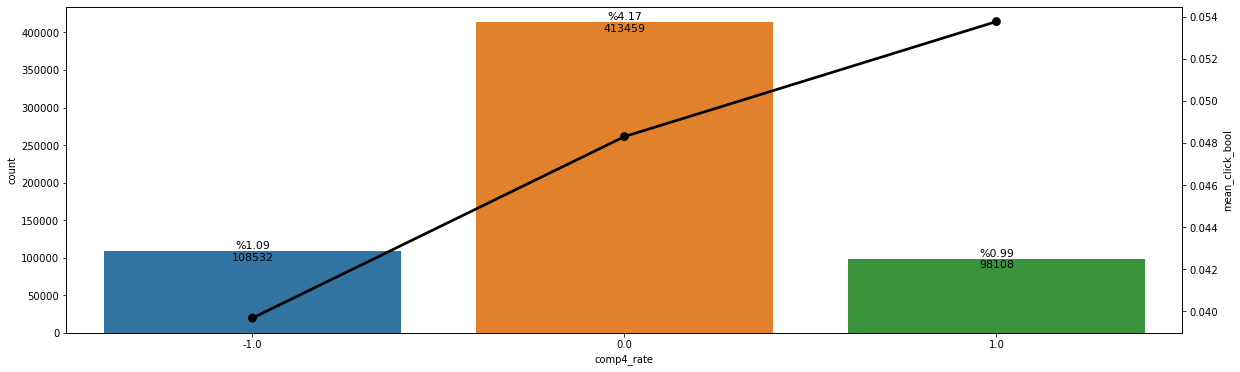

col: comp4_inv
Unique number: 4

Top 5 (value: number):

   comp4_inv  sample_num      frac    cumsum
0        0.0      607809  0.061286  0.061286
1        1.0       75543  0.007617  0.068903
2       -1.0        9119  0.000919  0.069823

Bottom 5 (value: number):

   comp4_inv  sample_num      frac    cumsum
0        0.0      607809  0.061286  0.061286
1        1.0       75543  0.007617  0.068903
2       -1.0        9119  0.000919  0.069823


<Figure size 1440x432 with 0 Axes>

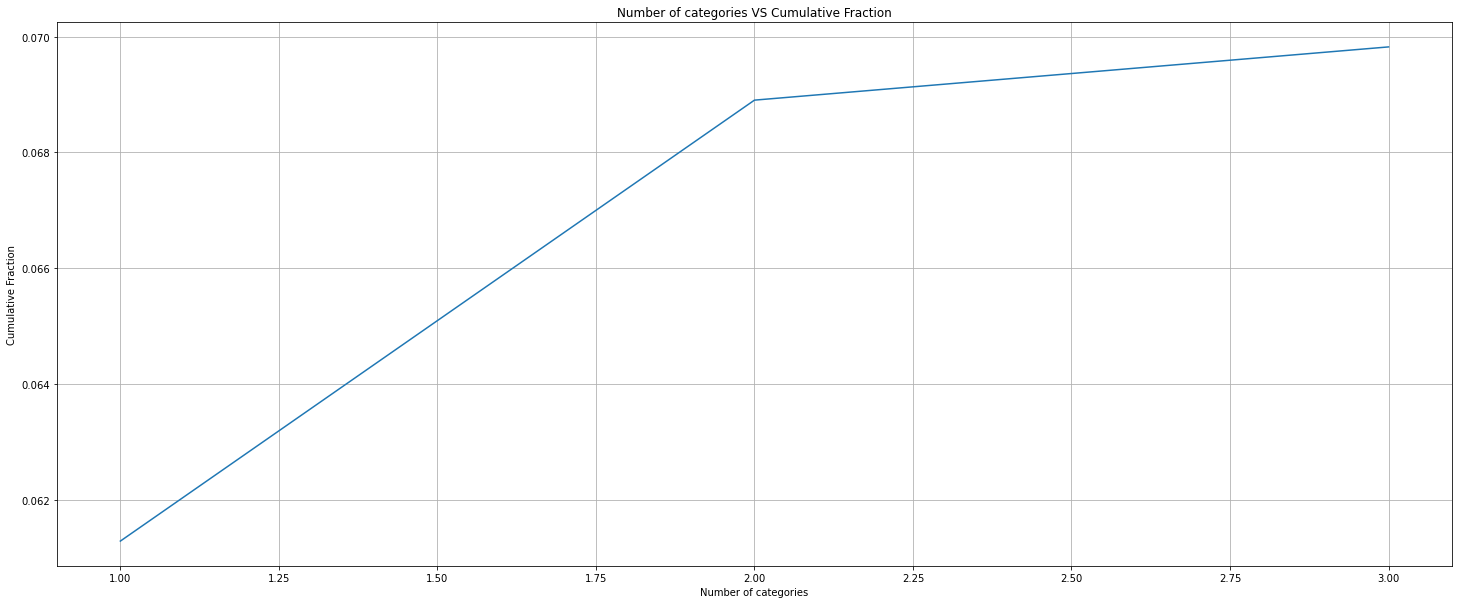

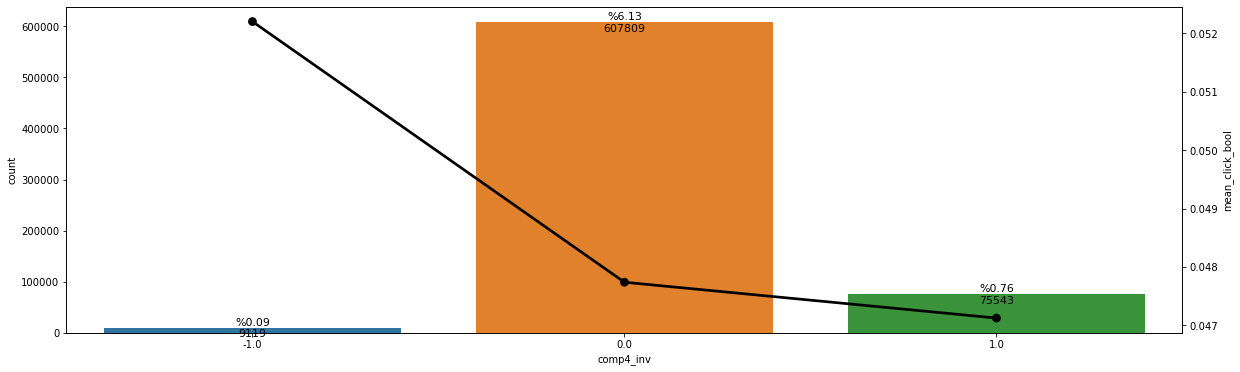

col: comp5_rate
Unique number: 4

Top 5 (value: number):

   comp5_rate  sample_num      frac    cumsum
0         0.0     3234017  0.326091  0.326091
1         1.0      655637  0.066109  0.392200
2        -1.0      554640  0.055925  0.448125

Bottom 5 (value: number):

   comp5_rate  sample_num      frac    cumsum
0         0.0     3234017  0.326091  0.326091
1         1.0      655637  0.066109  0.392200
2        -1.0      554640  0.055925  0.448125


<Figure size 1440x432 with 0 Axes>

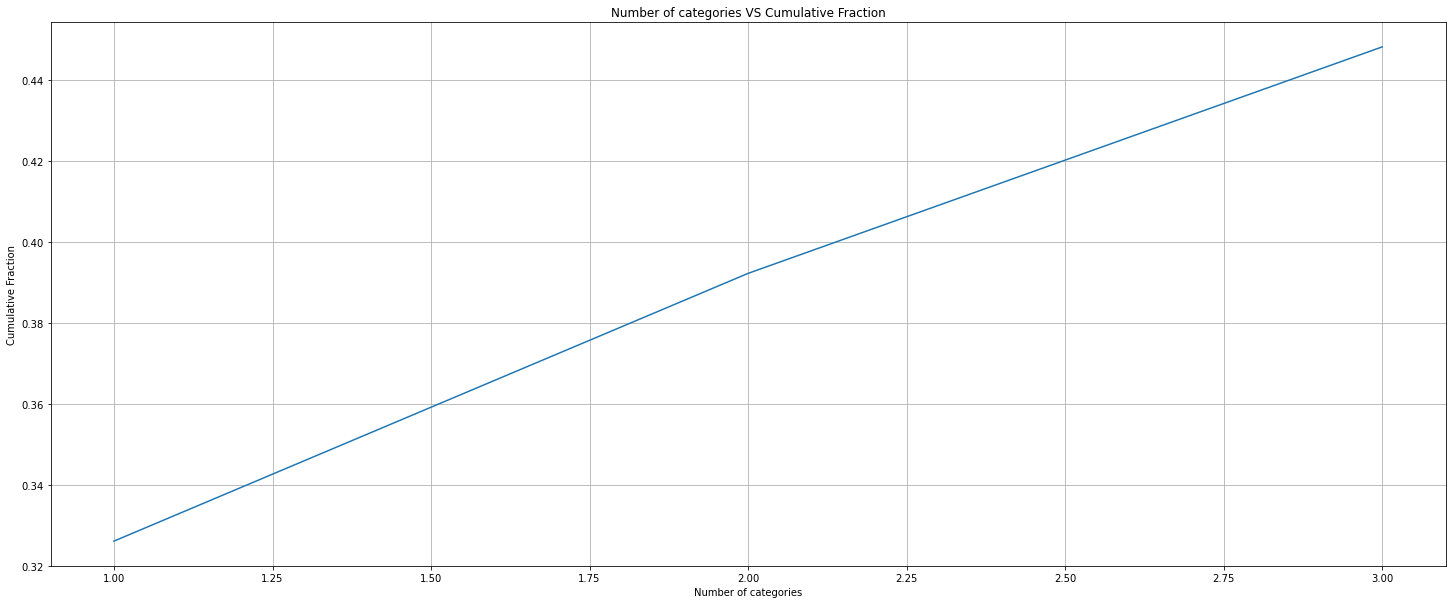

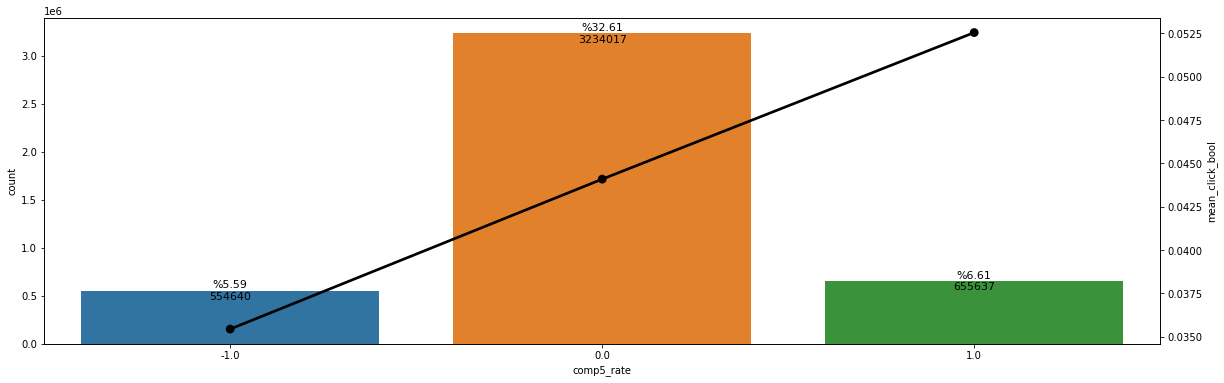

col: comp5_inv
Unique number: 4

Top 5 (value: number):

   comp5_inv  sample_num      frac    cumsum
0        0.0     4368523  0.440485  0.440485
1        1.0      298564  0.030105  0.470590
2       -1.0       53746  0.005419  0.476009

Bottom 5 (value: number):

   comp5_inv  sample_num      frac    cumsum
0        0.0     4368523  0.440485  0.440485
1        1.0      298564  0.030105  0.470590
2       -1.0       53746  0.005419  0.476009


<Figure size 1440x432 with 0 Axes>

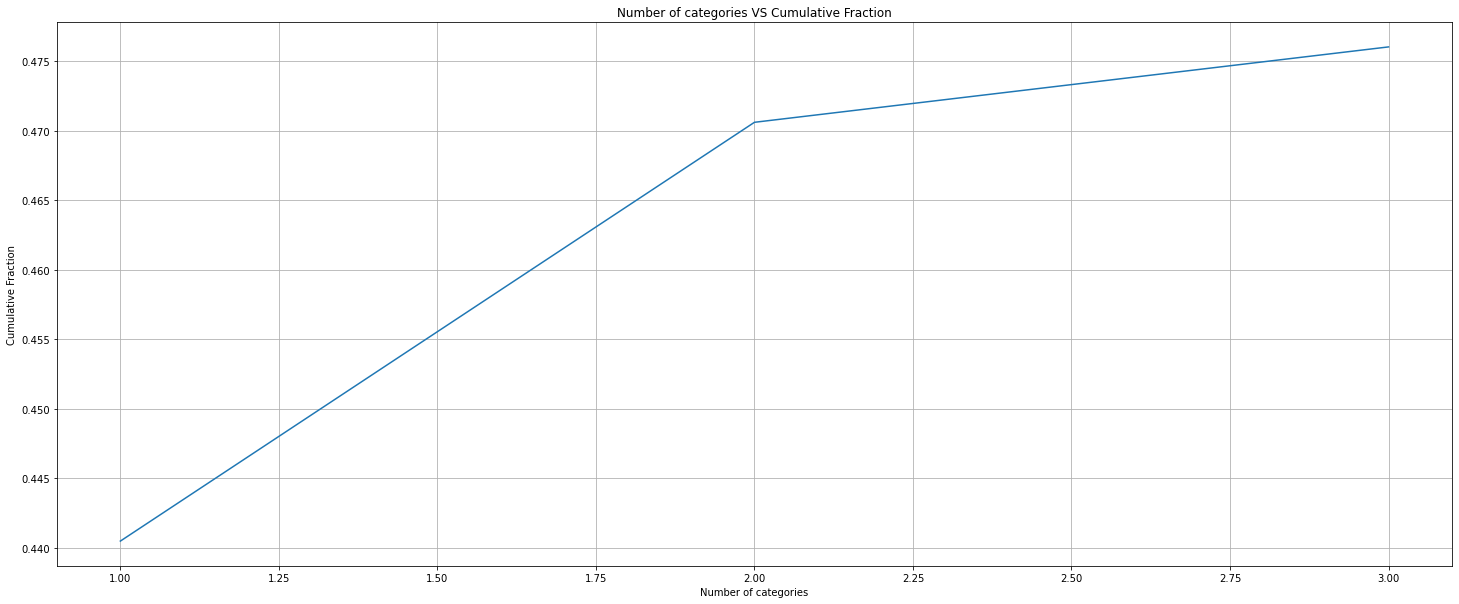

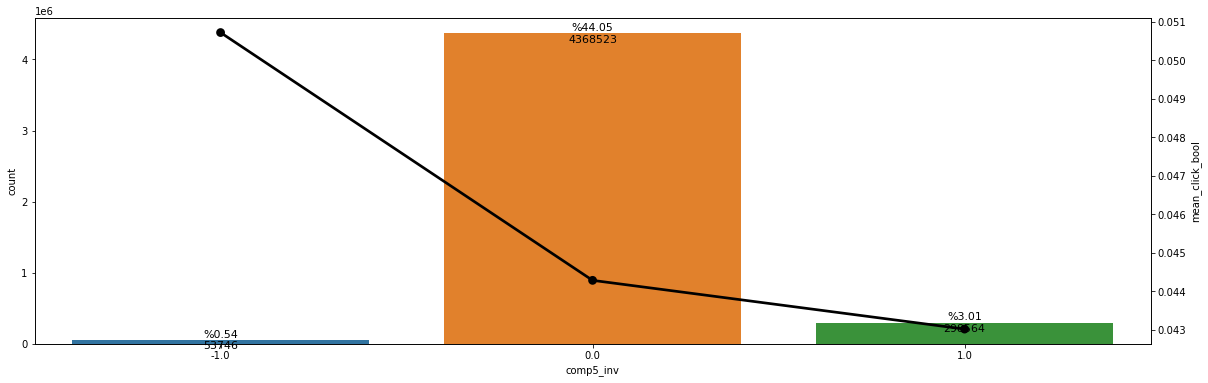

col: comp6_rate
Unique number: 4

Top 5 (value: number):

   comp6_rate  sample_num      frac    cumsum
0         0.0      323036  0.032572  0.032572
1         1.0      110840  0.011176  0.043748
2        -1.0       48611  0.004902  0.048650

Bottom 5 (value: number):

   comp6_rate  sample_num      frac    cumsum
0         0.0      323036  0.032572  0.032572
1         1.0      110840  0.011176  0.043748
2        -1.0       48611  0.004902  0.048650


<Figure size 1440x432 with 0 Axes>

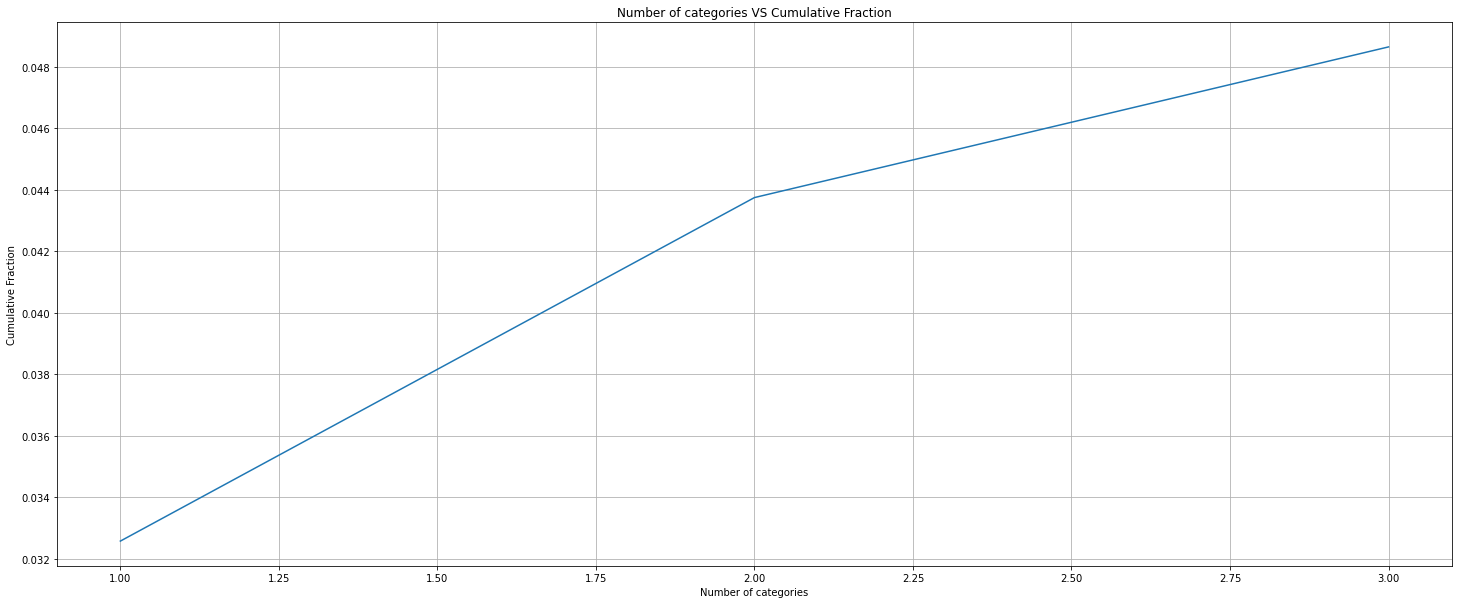

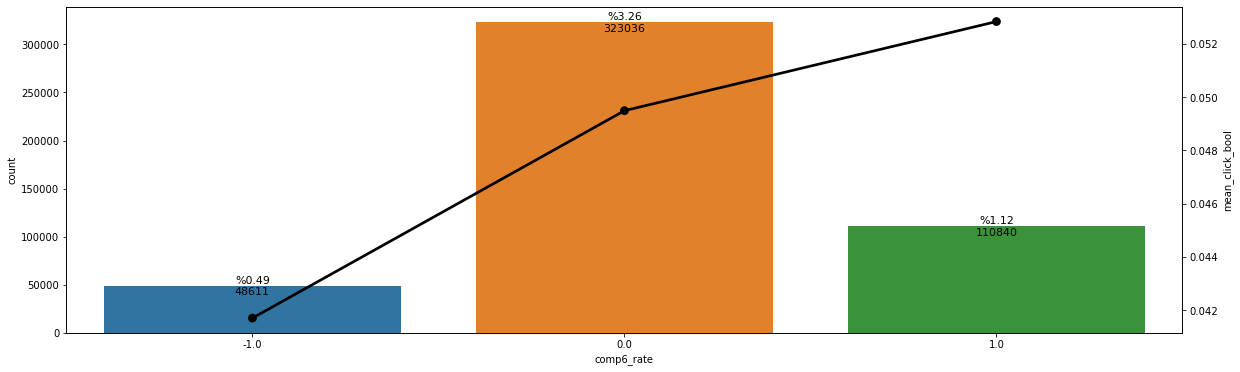

col: comp6_inv
Unique number: 4

Top 5 (value: number):

   comp6_inv  sample_num      frac    cumsum
0        0.0      473323  0.047726  0.047726
1        1.0       45237  0.004561  0.052287
2       -1.0        5585  0.000563  0.052850

Bottom 5 (value: number):

   comp6_inv  sample_num      frac    cumsum
0        0.0      473323  0.047726  0.047726
1        1.0       45237  0.004561  0.052287
2       -1.0        5585  0.000563  0.052850


<Figure size 1440x432 with 0 Axes>

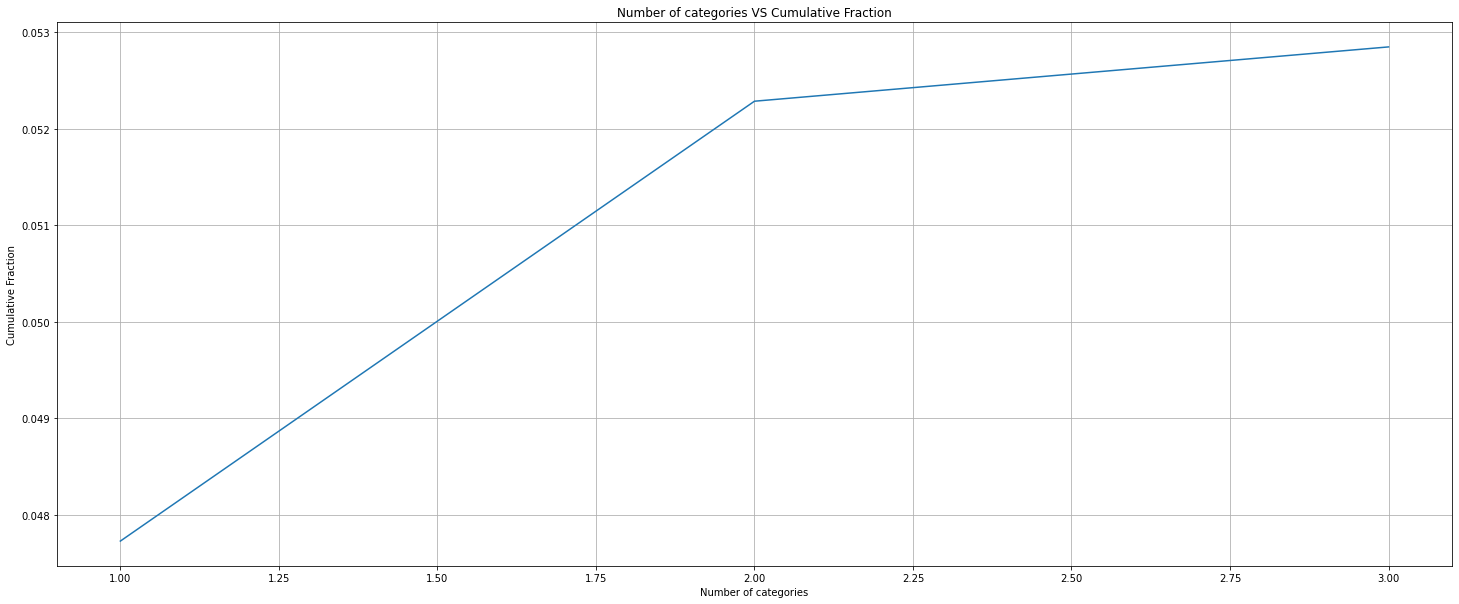

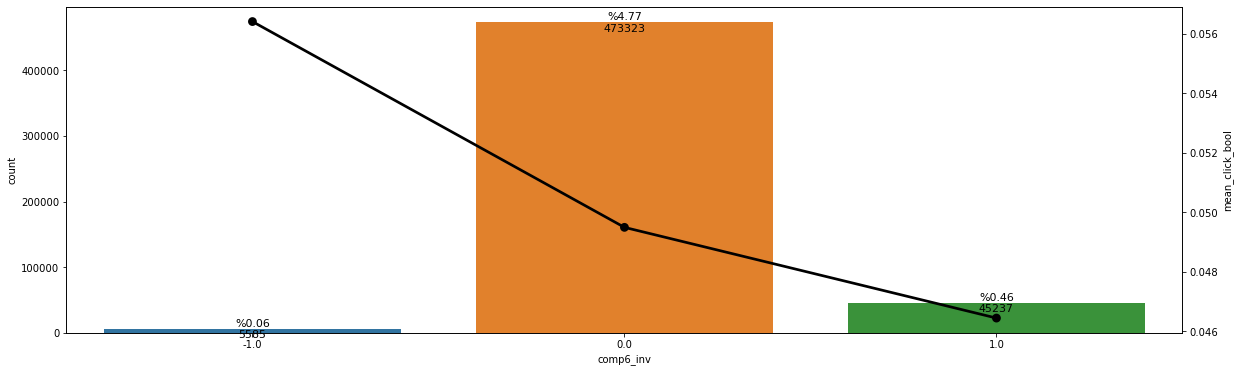

col: comp7_rate
Unique number: 4

Top 5 (value: number):

   comp7_rate  sample_num      frac    cumsum
0         0.0      406050  0.040943  0.040943
1         1.0      158917  0.016024  0.056967
2        -1.0       66110  0.006666  0.063632

Bottom 5 (value: number):

   comp7_rate  sample_num      frac    cumsum
0         0.0      406050  0.040943  0.040943
1         1.0      158917  0.016024  0.056967
2        -1.0       66110  0.006666  0.063632


<Figure size 1440x432 with 0 Axes>

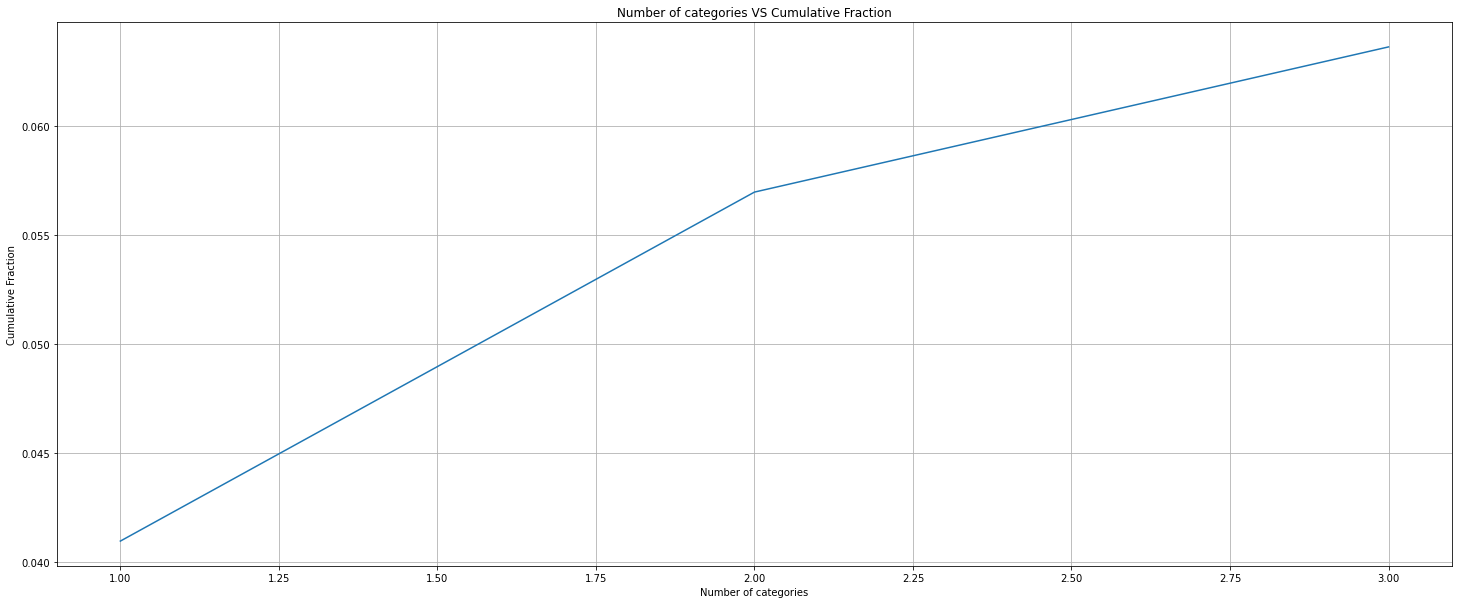

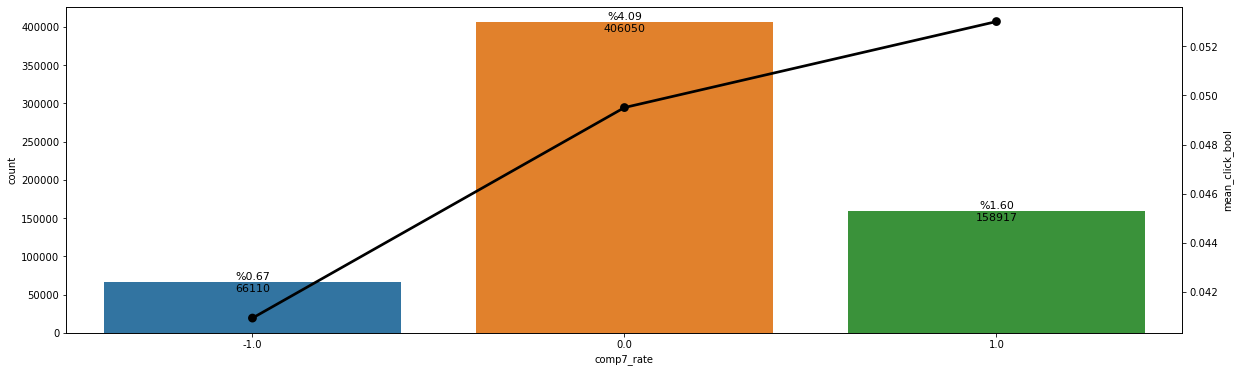

col: comp7_inv
Unique number: 4

Top 5 (value: number):

   comp7_inv  sample_num      frac    cumsum
0        0.0      637060  0.064236  0.064236
1        1.0       67390  0.006795  0.071031
2       -1.0        8725  0.000880  0.071911

Bottom 5 (value: number):

   comp7_inv  sample_num      frac    cumsum
0        0.0      637060  0.064236  0.064236
1        1.0       67390  0.006795  0.071031
2       -1.0        8725  0.000880  0.071911


<Figure size 1440x432 with 0 Axes>

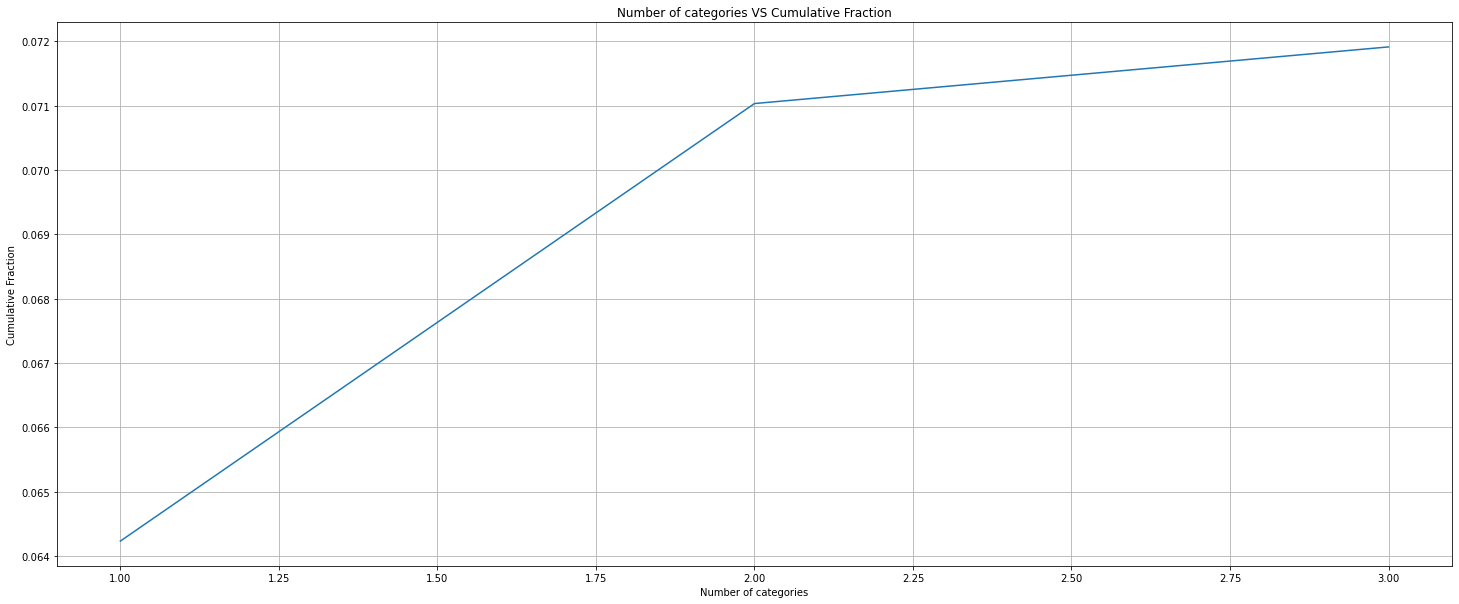

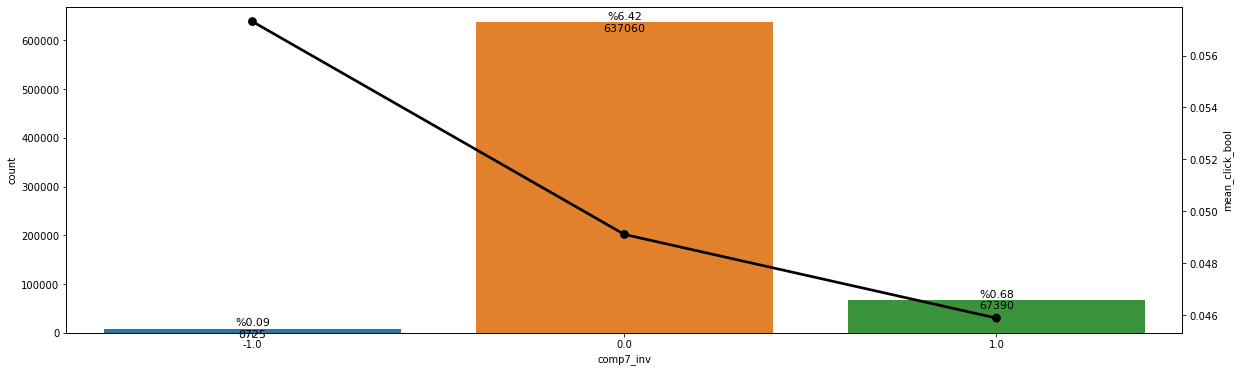

col: comp8_rate
Unique number: 4

Top 5 (value: number):

   comp8_rate  sample_num      frac    cumsum
0         0.0     2964040  0.298869  0.298869
1        -1.0      543457  0.054798  0.353666
2         1.0      311546  0.031414  0.385080

Bottom 5 (value: number):

   comp8_rate  sample_num      frac    cumsum
0         0.0     2964040  0.298869  0.298869
1        -1.0      543457  0.054798  0.353666
2         1.0      311546  0.031414  0.385080


<Figure size 1440x432 with 0 Axes>

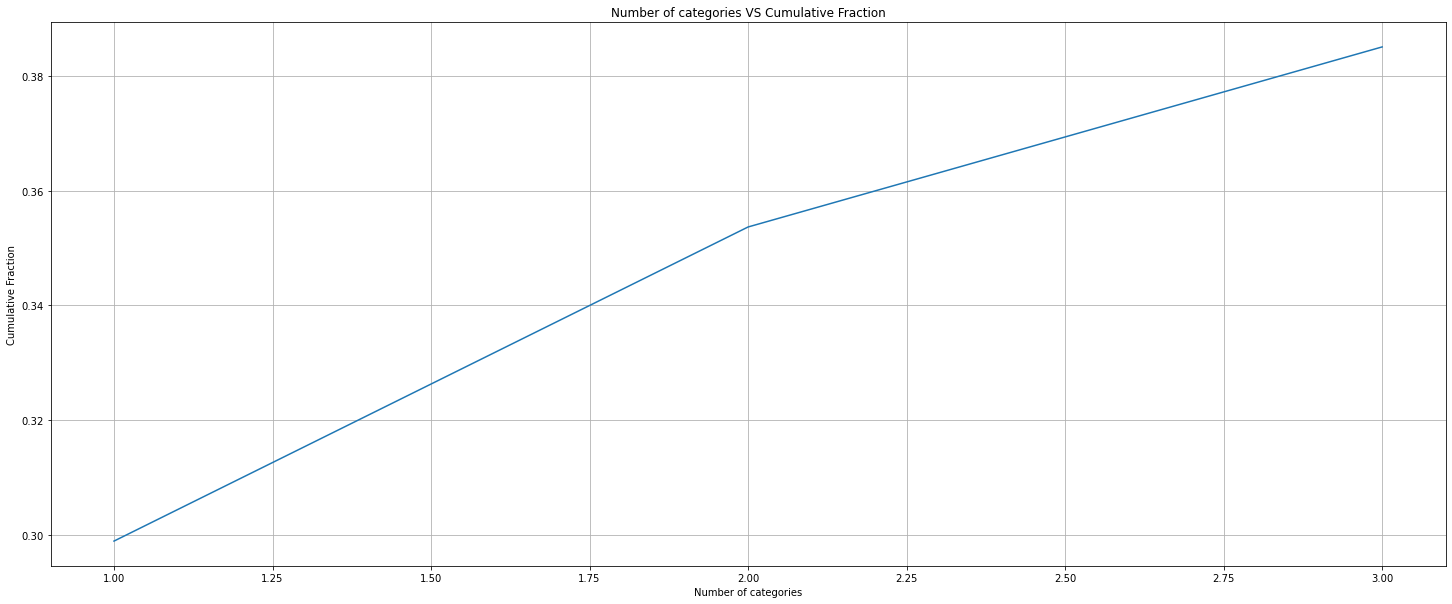

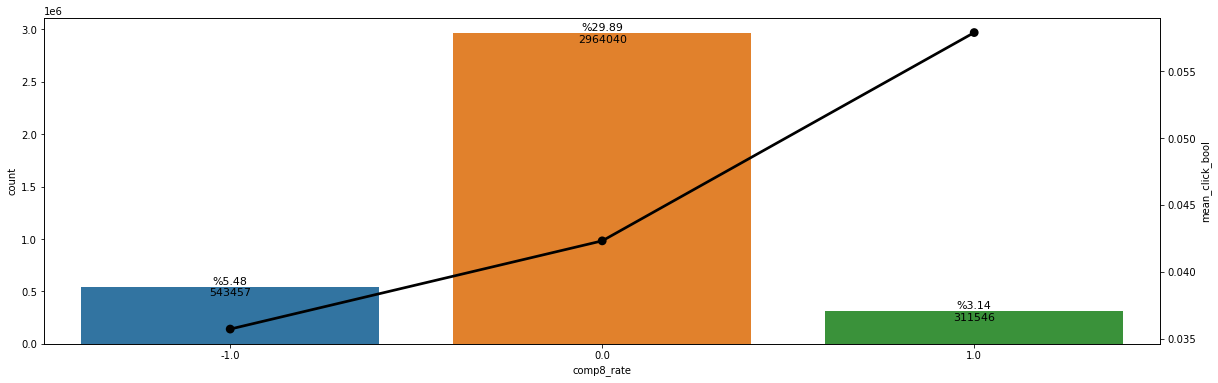

col: comp8_inv
Unique number: 4

Top 5 (value: number):

   comp8_inv  sample_num      frac    cumsum
0        0.0     3796532  0.382810  0.382810
1        1.0      101511  0.010236  0.393046
2       -1.0       62345  0.006286  0.399332

Bottom 5 (value: number):

   comp8_inv  sample_num      frac    cumsum
0        0.0     3796532  0.382810  0.382810
1        1.0      101511  0.010236  0.393046
2       -1.0       62345  0.006286  0.399332


<Figure size 1440x432 with 0 Axes>

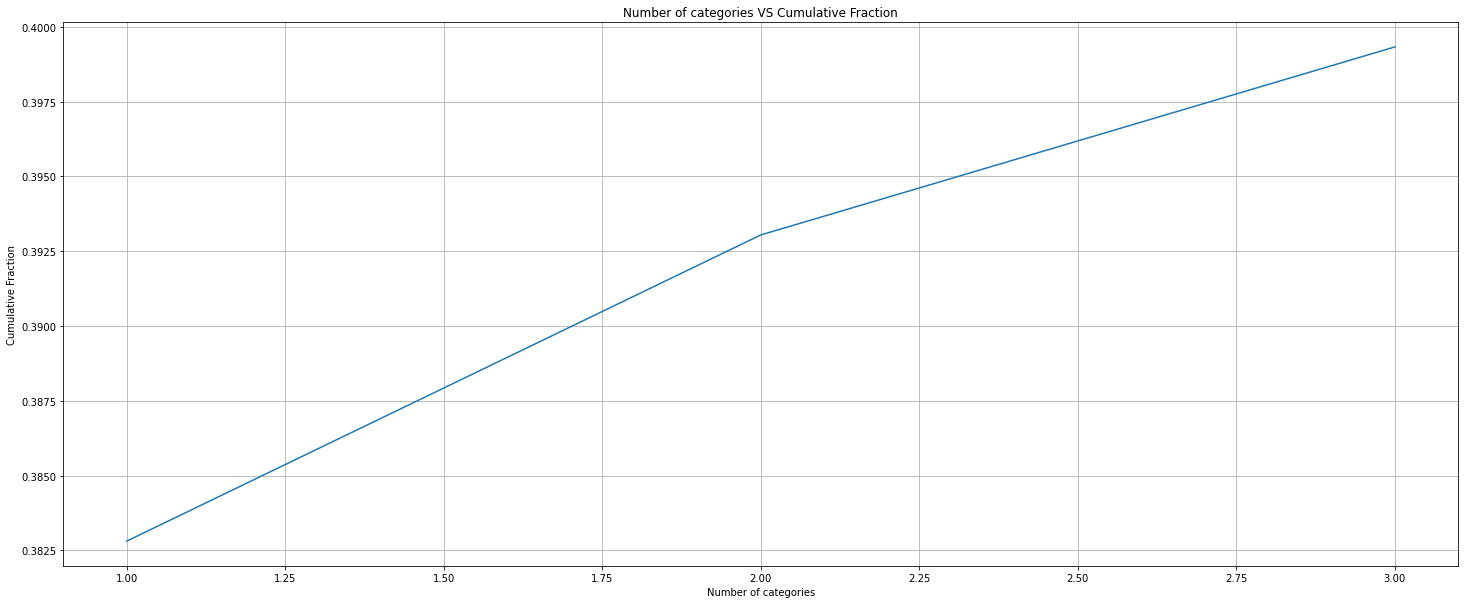

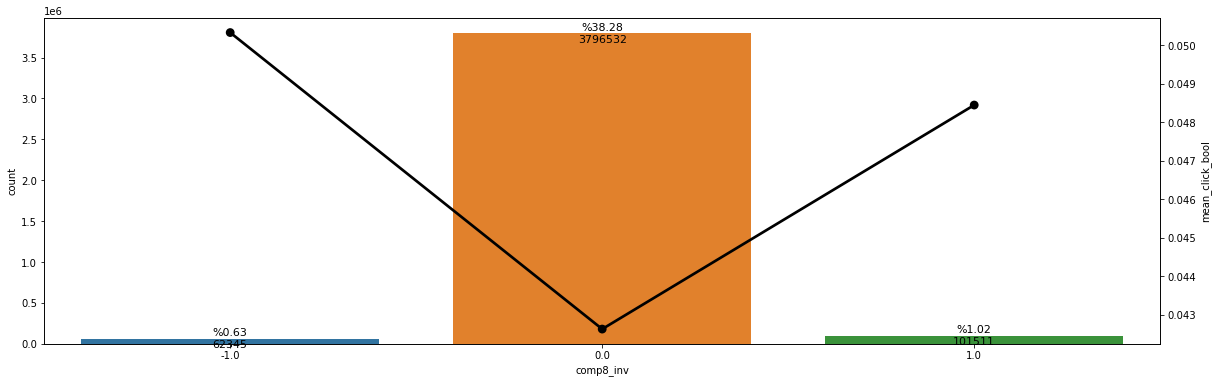

col: month


KeyError: 'month'

<Figure size 1440x432 with 0 Axes>

In [21]:
df = all_df
target = 'click_bool'
for col in sparse_features:
    print('='*20)
    print(f"col: {col}")
    unique_num = len(df[col].unique())
    stats = value_count_stats(df=df, col=col)
    print(f"Unique number: {unique_num}")
    print('='*20)
    print()
    print("Top 5 (value: number):")
    print()
    print(stats.head(5))
    print()
    print("Bottom 5 (value: number):")
    print()
    print(stats.tail(5))
    stats_plot(stats=stats)
    count_plot(df=df, col=col, regression_target=target)

# Dense Feature 

## Price_usd

<AxesSubplot:>

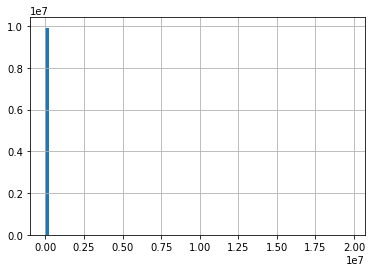

In [29]:
all_df['price_usd'].hist(bins=80)

<AxesSubplot:>

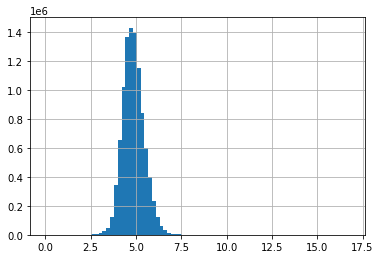

In [31]:
np.log(all_df['price_usd']+1).hist(bins=80)

In [26]:
all_df['price_usd'].describe([0.05*i for i in range(20)])

count    9.917530e+06
mean     2.417826e+02
std      1.434181e+04
min      0.000000e+00
0%       0.000000e+00
5%       5.100000e+01
10%      6.100000e+01
15%      7.000000e+01
20%      7.890000e+01
25%      8.500000e+01
30%      9.211000e+01
35%      9.900000e+01
40%      1.070000e+02
45%      1.147300e+02
50%      1.220700e+02
55%      1.310000e+02
60%      1.420000e+02
65%      1.540000e+02
70%      1.690000e+02
75%      1.850000e+02
80%      2.050000e+02
85%      2.340000e+02
90%      2.770900e+02
95%      3.560000e+02
max      1.972633e+07
Name: price_usd, dtype: float64

In [32]:
np.log(all_df['price_usd']+1).describe([0.05*i for i in range(20)])

count    9.917530e+06
mean     4.856217e+00
std      6.143284e-01
min      0.000000e+00
0%       0.000000e+00
5%       3.951244e+00
10%      4.127134e+00
15%      4.262680e+00
20%      4.380776e+00
25%      4.454347e+00
30%      4.533782e+00
35%      4.605170e+00
40%      4.682131e+00
45%      4.751260e+00
50%      4.812753e+00
55%      4.882802e+00
60%      4.962845e+00
65%      5.043425e+00
70%      5.135798e+00
75%      5.225747e+00
80%      5.327876e+00
85%      5.459586e+00
90%      5.627945e+00
95%      5.877736e+00
max      1.679746e+01
Name: price_usd, dtype: float64

<AxesSubplot:>

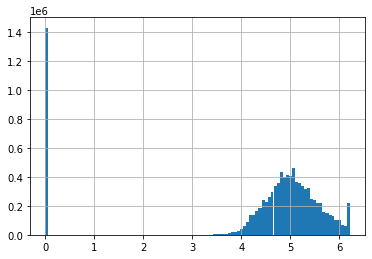

In [34]:
all_df['prop_log_historical_price'].hist(bins=100)

In [36]:
np.exp(all_df['prop_log_historical_price']).describe([0.05*i for i in range(20)])

count    9.917530e+06
mean              NaN
std               NaN
min      1.000000e+00
0%       1.000000e+00
5%       1.000000e+00
10%      1.000000e+00
15%      4.696875e+01
20%      7.231250e+01
25%      8.487500e+01
30%      9.656250e+01
35%      1.068750e+02
40%      1.169375e+02
45%      1.264375e+02
50%      1.356250e+02
55%      1.466250e+02
60%      1.573750e+02
65%      1.708750e+02
70%      1.847500e+02
75%      2.021250e+02
80%      2.262500e+02
85%      2.545000e+02
90%      2.987500e+02
95%      3.730000e+02
max      4.982500e+02
Name: prop_log_historical_price, dtype: float64